In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import numba

from sample_processing import *
from gibbs_sampler import *
%load_ext autoreload
%autoreload 2

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/912227337.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def calc_c_vals(cluster_sol, similarity_mat):
    
    c_vals = np.zeros(len(cluster_sol))
    for i in range(len(cluster_sol)):

        point_clust = cluster_sol[i]
        point_sims = similarity_mat[i]

        neighbs = np.where(cluster_sol==point_clust)[0]
        neighbs_sim = point_sims[neighbs]
        c_val_i = np.mean(neighbs_sim)
        c_vals[i] = c_val_i
        
        return c_vals
    
def confidence_matrix(cluster_sol, similarity_mat):
    
    # Get names of clusters
    sorted_clust_names = pd.Series(cluster_sol).value_counts().index

    # Re-arrange IDs and form new sorted similarity matrix
    arranged_ids = []
    for c in sorted_clust_names:

        clust_ids = np.where(cluster_sol==c)[0]
        c_vals_clust = c_vals[clust_ids]
        sorted_clust_ids =clust_ids[np.argsort(c_vals_clust)[::-1]]

        arranged_ids.append(sorted_clust_ids)

    arranged_ids = np.concatenate(arranged_ids)

    sorted_matrix = np.zeros((len(cluster_sol),len(cluster_sol)))

    for i in range(len(cluster_sol)):
        for j in range(len(cluster_sol)):

            sorted_matrix[i,j] = sim_mat[arranged_ids[i], arranged_ids[j]]

# Prelim on Wildfire Data

In [3]:
# Create a StringIO object to simulate reading from a file-like object
from io import StringIO


def extract_state(input_string):
    # Use regular expression to extract text between five asterisks
    result = re.search(r'\*{5}\s*(.*?)\s*\*{1,5}', input_string)
    
    if result:
        extracted_text = result.group(1)
        return extracted_text
    else:
        return ""

def extract_content(in_string):
    fake_file = StringIO(in_string)

    # Define column widths based on the fixed-width format
    colspecs = [
        (0, 7), (7, 25), (25, 31), (31, 36), (36, 42),
        (42, 46), (47, 51), (51, 56), (56, 61), (62, 68),
        (68, 73), (73, 78), (78, 83), (83, 88), (89, 94),
        (94, 100), (101, 106), (106, 111), (111, 115), (115, 120)
    ]

    # Column names
    columns = ['Stn ID', 'Stn Name', 'Elev', 'Lat', 'Long',
               'Mdl', 'Tmp', 'RH', 'Wind', 'PPT',
               'ERC', 'BI', 'SC', 'KBDI', 'HUN',
               'THOU', 'TEN', 'STL', 'ADJ', 'IC']

    # Read the fixed-width format data into a DataFrame
    df = pd.read_fwf(fake_file, colspecs=colspecs, names=columns)
    
    return df

Load older dataset - For State names

In [4]:
import pandas as pd
import re

# Read the text file
with open('Datasets/FDR_Raw/fdr_obs_2018_08_19.txt', 'r') as file:
    lines = file.readlines()


# Initialize empty lists to store data
data = {'Stn ID': [], 'Stn Name': [], 'Elev': [], 'Lat': [], 'Long': [],
        'Mdl': [], 'Tmp': [], 'RH': [], 'Wind': [], 'PPT': [],
        'ERC': [], 'BI': [], 'SC': [], 'KBDI': [], 'HUN': [],
        'THOU': [], 'TEN': [], 'STL': [], 'ADJ': [], 'IC': []}

# Regular expression to match station information
station_info_pattern = re.compile(r'\s*(\d+)\s+(\w+)\s+([\d.-]+)\s+([\d.-]+)\s+(\w+)\s+(\d+)\s+(\d+)\s+(\d+)\s+([\d.]+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\w+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\w+)\s+(\w+)\s+(\w+)\s+(\w+)')

# Flag to check if the station information block has started
in_station_block = False
df_store = []
# Iterate through lines and extract data

for line in lines[5:]:
    if '*****' in line:
        # Extract state name
        current_state_name = extract_state(line)
        # Switch the flag when reaching the start of a station block
        in_station_block = not in_station_block        

    line_content = extract_content(line)
    
    if (len(line_content['Stn ID'])==0) or (type(line_content['Stn ID'][0]) == str):
        continue
    else:
        line_content['State'] = current_state_name
        df_store.append(line_content)
        
    
# Create a Pandas DataFrame
wildfire_df_2018 = pd.concat(df_store)



# Load Xu Dataset

In [5]:
wildfire_df_xu = pd.read_csv('Datasets/Xuchen_Data.txt')
wildfire_df_xu.columns = ['Elev', 'Lat', 'Long', 'Mdl', 'Tmp', 'RH', 'Wind', 'PPT',
       'ERC', 'BI', 'SC', 'KBDI', 'HUN', 'THOU', 'TEN',
       'STL', 'ADJ', 'I']

In [6]:
wildfire_df_xu['Elev'] = wildfire_df_xu['Elev'].str.strip()

# Some cleaning
wildfire_df_xu = wildfire_df_xu[wildfire_df_xu['Elev']!='']
wildfire_df_xu.reset_index(drop=True, inplace=True)

In [7]:
wildfire_df_xu['Elev'] = wildfire_df_xu['Elev'].astype('float')

In [8]:
states = []
for i in range(len(wildfire_df_xu)):
    
    lat_i = wildfire_df_xu['Lat'][i]
    long_i = wildfire_df_xu['Long'][i]

    
    matched_row = wildfire_df_2018[(wildfire_df_2018['Lat']==lat_i) &\
                                   (wildfire_df_2018['Long']==long_i)]

    if len(matched_row) == 0:
        state = None
    
    else:
        state = matched_row['State'].iloc[0]
    
    states.append(state)
    
wildfire_df_xu['State'] = states

In [9]:
wildfire_df_xu.head()

Elev   Lat  Long   Mdl  Tmp  RH  Wind   PPT  ERC  BI  SC  KBDI  HUN  \
0   663.0  34.7  86.4   7G    91  47     4  0.00   32  25   3   695   15   
1   970.0  34.3  87.3   7G    86  56     3  0.00   28  22   3   578   15   
2  1200.0  34.4  85.6   7G    72  71     2  0.00   20  13   1   278   17   
3  1104.0  33.9  86.3   7G    79  74     1  0.31   21  13   1   512   17   
4  1050.0  33.7  85.7   8G    84  48     1  0.00   28  28   5   619   14   

   THOU  TEN    STL   ADJ   I    State  
0    17    9     3     M   12     None  
1    18   11     4     M    7  Alabama  
2    20   15     2     L    2  Alabama  
3    19   15     3     M    2     None  
4    17   10     3     M   11  Alabama

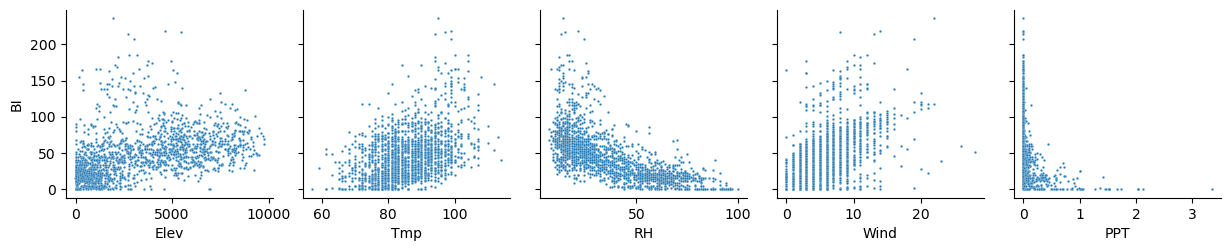

In [12]:
import seaborn as sns

sns.pairplot(wildfire_df_xu,
            x_vars=["Elev", "Tmp", "RH","Wind","PPT"],
            y_vars=['BI'],plot_kws={"s": 3})

In [11]:
wildfire_df_xu = wildfire_df_xu[wildfire_df_xu['Tmp']>10]

Pre-processing - Normalize inputs to -1 - 1

In [13]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler(feature_range=(-0.99, 0.99),copy=True, clip=False)

for s in ["Elev", "Tmp", "RH","Wind","PPT"]:
    scaler = MinMaxScaler(feature_range=(-1, 1),copy=True, clip=False)
    transformed_values = scaler.fit_transform(np.expand_dims(wildfire_df_xu[s].values,1)).reshape(-1)
    
    wildfire_df_xu[s+'_standard'] = transformed_values
    
scaler = StandardScaler(copy=True)
bi_transformed_values = scaler.fit_transform(np.expand_dims(wildfire_df_xu['BI'].values,1)).reshape(-1)
wildfire_df_xu['BI_standard'] = bi_transformed_values

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/4177019970.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfire_df_xu[s+'_standard'] = transformed_values
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/4177019970.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfire_df_xu[s+'_standard'] = transformed_values
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/4177019970.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [14]:
#wildfire_df_xu = wildfire_df_xu[wildfire_df_xu['Tmp_standard']>-0.6]

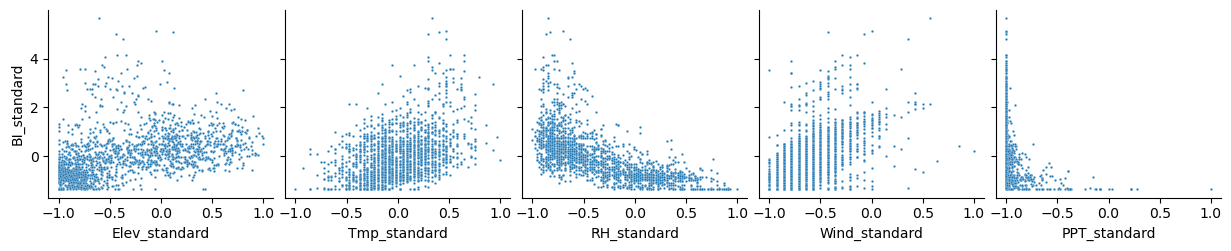

In [15]:
sns.pairplot(wildfire_df_xu,
            x_vars=["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard","PPT_standard"],
            y_vars=['BI_standard'],plot_kws={"s": 3})

Take a subet

Plot on Map

In [16]:
np.random.seed(0)
wildfire_df_xu_sub = wildfire_df_xu#.sample(n=1852)


## Fit Single QR Model First


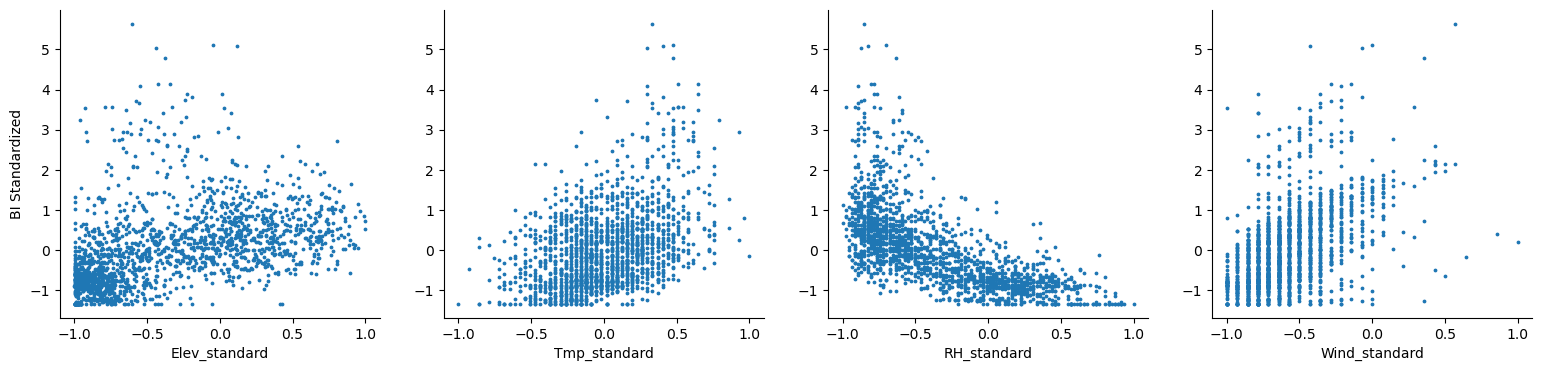

In [17]:
fig, ax = plt.subplots(1,4, figsize=(19,4))
for i,x_var_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):
    
    ax[i].scatter(wildfire_df_xu_sub[x_var_name],
                  wildfire_df_xu_sub['BI_standard'], s= 3)
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_xlabel(x_var_name)
    
    if i ==0:
        ax[i].set_ylabel('BI Standardized')
        
plt.savefig('Exp Results/Xu Dataset/Multivar Run 4/Param Plot.png')

In [18]:
import arviz as az
from Single_Var_QR import SingleQRSampler_T_4_block


Fit Multivariate model


In [19]:
np.random.seed(1234)

In [20]:
x_var = wildfire_df_xu_sub[["Elev_standard", "Tmp_standard",
                            "RH_standard","Wind_standard"]].values
y_var = wildfire_df_xu_sub['BI_standard'].values


quantile_dist = 't'
prior_on_t = True

# Choose no. of chains
n_chains = 1
n_steps = 20000
n_burn_in = 5000

# Set Grid of tau values
tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
knot_points_grid = np.arange(0.1,1,0.1)

data_size = len(x_var)
tau_upper_tail = 1-1/(2*data_size)
tau_lower_tail = 1/(2*data_size)
lower_seq = np.flip(geometric_seq(0.01, tau_lower_tail, 0.005, upper=False))
upper_seq = geometric_seq(0.99, tau_upper_tail, 0.005)

tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])

# Run Sampler
sampler_collecter_4blockt = [SingleQRSampler_T_4_block(y_var,
                                    x_var,          
                                    C_1 = 0.3,
                                    lambda_step_size_1 = 3,
                                    alpha_step_size_1 = 0.4,
                                    a_target_1 = 0.228,
                                    C_2 = 0.3,
                                    lambda_step_size_2 = 3,
                                    alpha_step_size_2 = 0.4,
                                    a_target_2 = 0.228,
                                    C_3 = 0.5,
                                    lambda_step_size_3 = 3,
                                    alpha_step_size_3 = 0.4,
                                    a_target_3 = 0.228,
                                    C_4 = 0.3,
                                    lambda_step_size_4 = 3,
                                    alpha_step_size_4 = 0.4,
                                    a_target_4 = 0.228,
                                    tau_grid_expanded = tau_grid_expanded,
                                    tau_grid = tau_grid,     
                                    knot_points_grid = knot_points_grid,
                                    am_lamb_block1_init = 2*(2.38**2)/(9),
                                    am_lamb_block2_init = 2*(2.38**2)/(9),
                                    am_lamb_block3_init = 2*(2.38**2)/(4 + 4 + 4),
                                    am_lamb_block4_init = 2*(2.38**2)/(9*2+4 + 4 + 4),
                                    alpha_kappa = 0.1,
                                    beta_kappa = 0.1,
                                    eps_1 = 0,
                                    eps_2 = 0,
                                    base_quantile_mean=0.0,
                                    base_quantile_sd=1.0,
                                    base_quantile_v=1.0,
                                    base_quantile_dist=quantile_dist,
                                    prior_on_t=prior_on_t,
                                    verbose=False,
                                    splice=True,
                                    track_block=True) for _ in range(n_chains)]

chain_outputs = [sampler_c.sample(n_steps=n_steps) for sampler_c in sampler_collecter_4blockt]

sampler_collecter = sampler_collecter_4blockt


Multivariate model
Track Block:  True
Step:  0  Time Taken:  5.104301929473877
Step:  5000  Time Taken:  51.63550806045532
Step:  10000  Time Taken:  50.908669233322144
Step:  15000  Time Taken:  50.35427212715149


In [21]:
from Single_Var_QR_utils import generate_beta_samples_multivar

In [22]:
tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])



b1_val_means = []
b1_lo_cis = []
b1_hi_cis = []
i=0
for a,sq in enumerate(tau_grid):
    
    output_samps = generate_beta_samples_multivar(tau_input=sq,
                                                tau_grid=tau_grid_expanded,
                                                w_approx_store=chain_outputs[i]['w'],
                                                mu_store=chain_outputs[i]['mu'],
                                                gamma_store=chain_outputs[i]['gamma'],
                                                sigma_1_store=chain_outputs[i]['sigma_1'],
                                                sigma_2_store=chain_outputs[i]['sigma_2'],
                                                X_alpha_store = chain_outputs[i]['X_alpha'],
                                                base_quantile_dist=quantile_dist,
                                                v_store=chain_outputs[i]['v'],
                                                X_vals=x_var)
    
    output_samps = np.vstack(output_samps)[n_burn_in:]
    b1_sq_mean_values = []
    b1_lo_ci_values = []
    b1_hi_ci_values = []
    for j in range(4):
        
        b1_i_sq_samps = output_samps[:,j]
        b1_i_sq_mean = np.mean(b1_i_sq_samps)
        b1_i_sq_lo_ci, b1_i_sq_hi_ci = az.hdi(b1_i_sq_samps)
        
        b1_sq_mean_values.append(b1_i_sq_mean)
        b1_lo_ci_values.append(b1_i_sq_lo_ci)
        b1_hi_ci_values.append(b1_i_sq_hi_ci)
        
        
    b1_val_means.append(np.array(b1_sq_mean_values))
    b1_lo_cis.append(np.array(b1_lo_ci_values))
    b1_hi_cis.append(np.array(b1_hi_ci_values))

b1_val_means = np.vstack(b1_val_means)
b1_lo_cis = np.vstack(b1_lo_cis)
b1_hi_cis = np.vstack(b1_hi_cis)

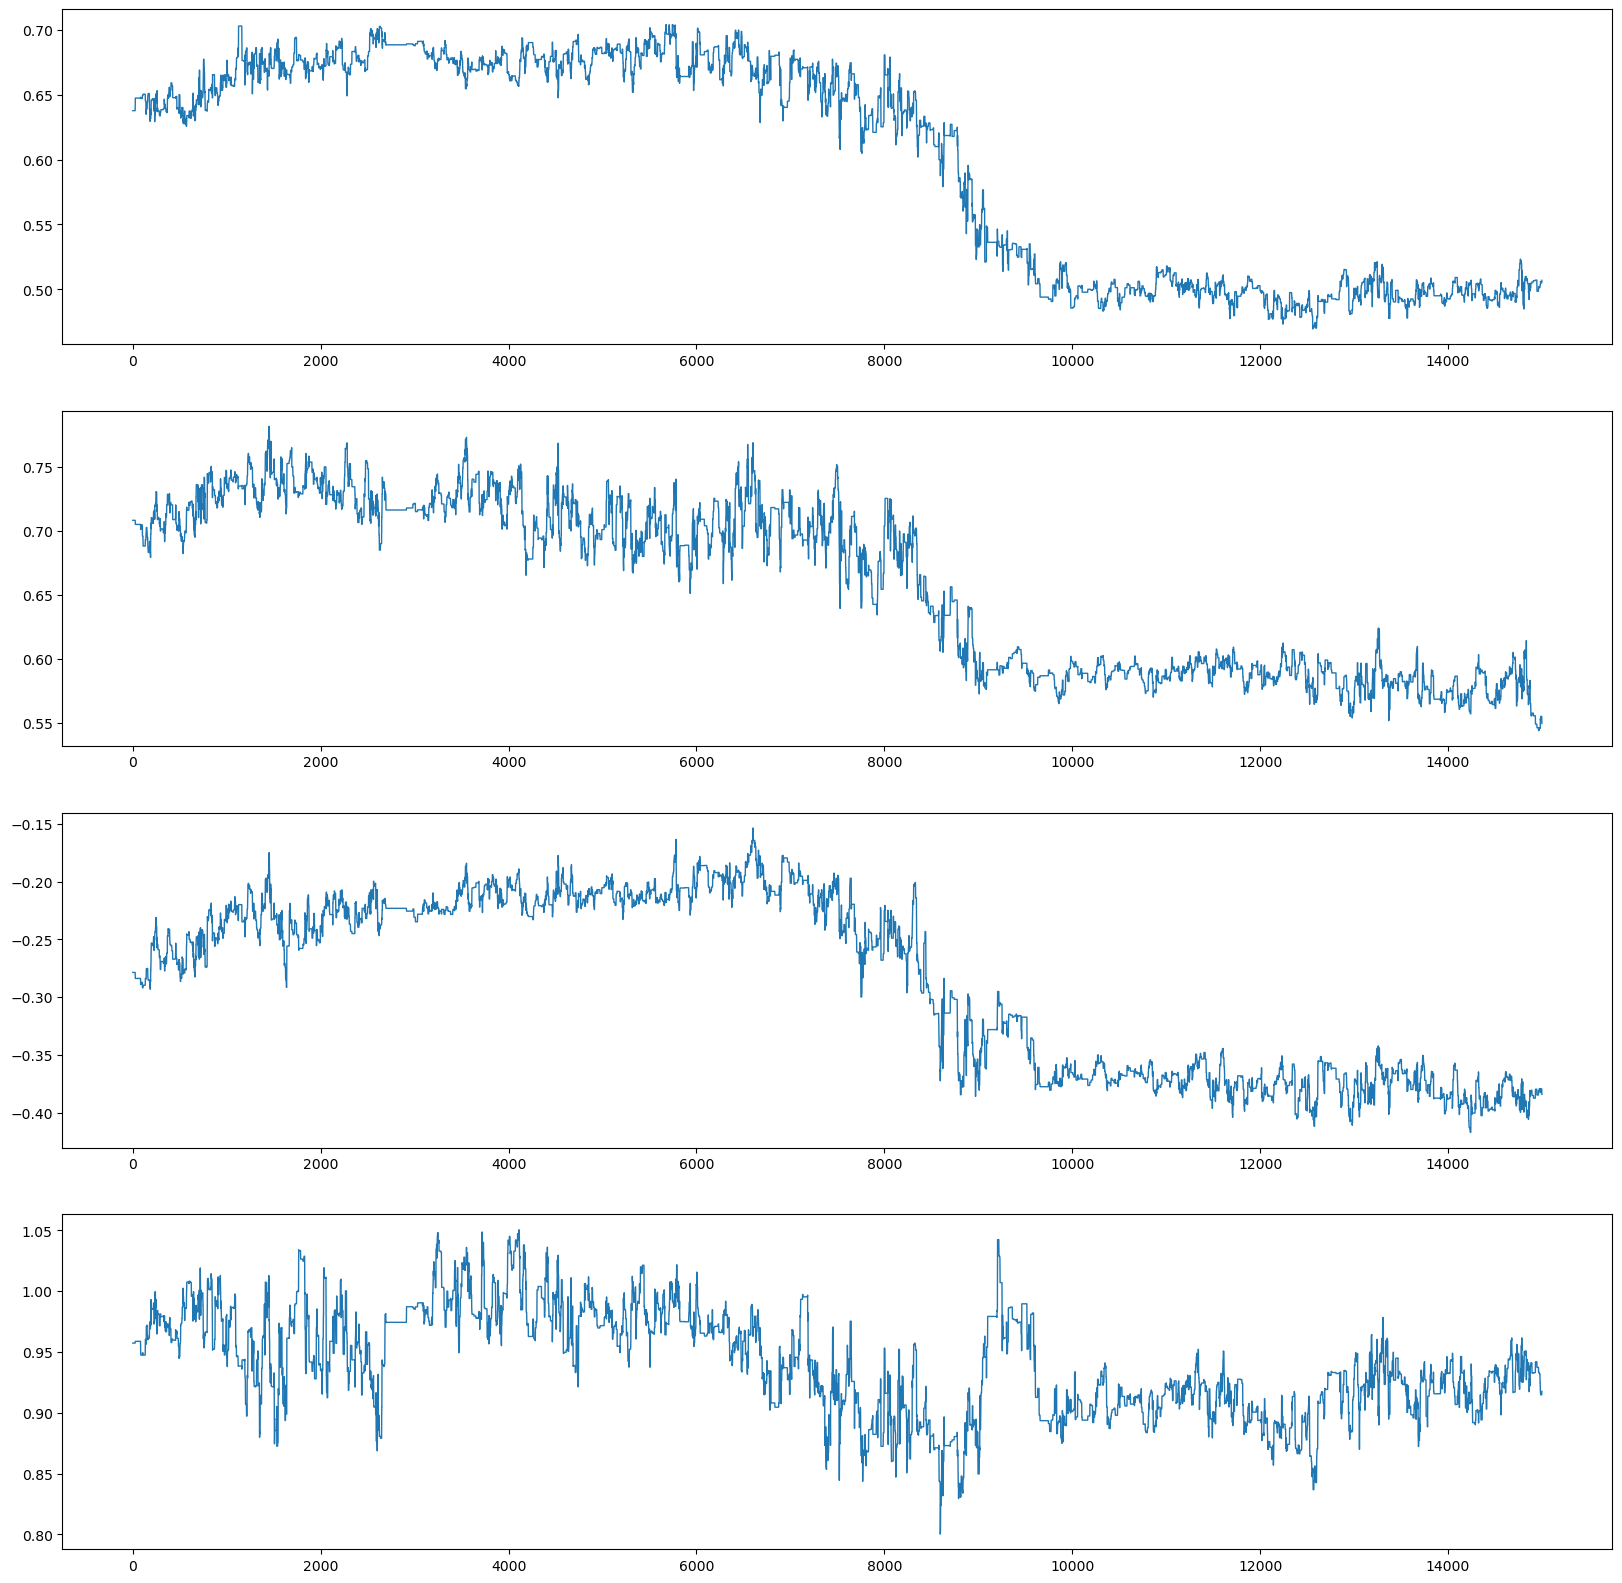

In [23]:
i=0
tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])
output_samps = generate_beta_samples_multivar(tau_input=tau_grid[50],
                                            tau_grid=tau_grid_expanded,
                                            w_approx_store=chain_outputs[i]['w'],
                                            mu_store=chain_outputs[i]['mu'],
                                            gamma_store=chain_outputs[i]['gamma'],
                                            sigma_1_store=chain_outputs[i]['sigma_1'],
                                            sigma_2_store=chain_outputs[i]['sigma_2'],
                                            X_alpha_store = chain_outputs[i]['X_alpha'],
                                            base_quantile_dist=quantile_dist,
                                            v_store=chain_outputs[i]['v'],
                                            X_vals=x_var)
output_samps = np.vstack(output_samps)[n_burn_in:]

fig,ax = plt.subplots(4,1,figsize=(20,20))
for i in range(4):
    ax[i].plot(output_samps[:,i],lw=1)

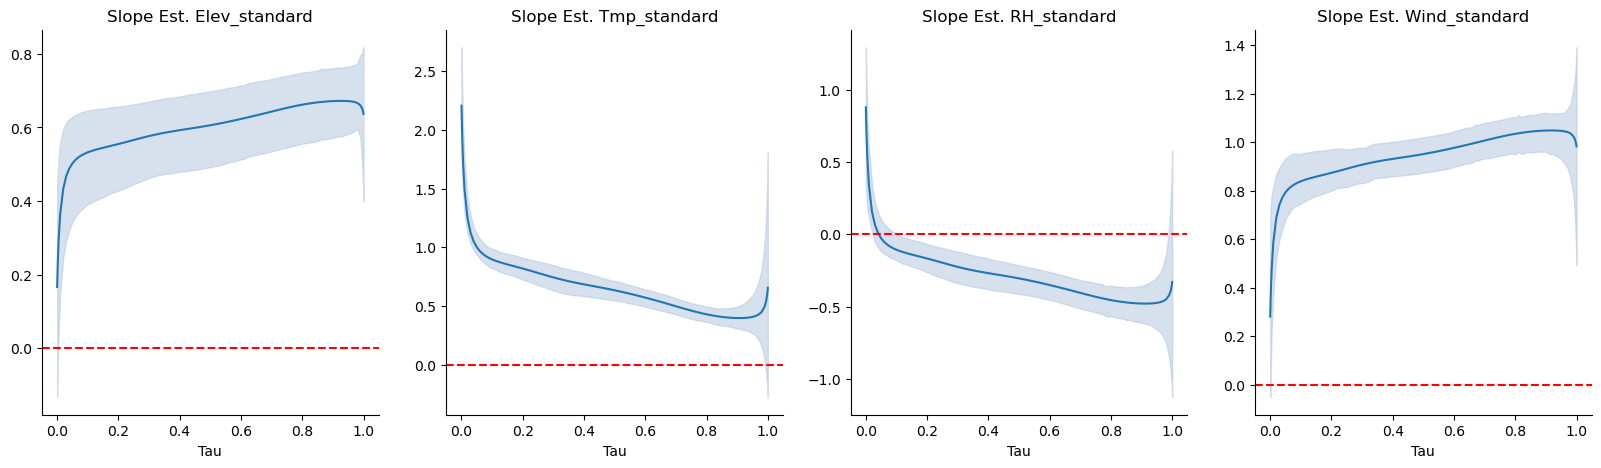

In [24]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for i,covar_name in enumerate(["Elev_standard", "Tmp_standard",
                            "RH_standard","Wind_standard"]):
    
    covar_means = b1_val_means[:,i]
    covar_lo_ci = b1_lo_cis[:,i]
    covar_hi_ci = b1_hi_cis[:,i]
    
    ax[i].plot(tau_grid,covar_means,color='tab:blue')
    ax[i].fill_between(tau_grid, covar_lo_ci,
                covar_hi_ci, color='lightsteelblue', alpha=.5)
    ax[i].axhline(0,color='red',linestyle='--')
    
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_xlabel('Tau')
    ax[i].title.set_text(f"Slope Est. {covar_name}")
    
plt.savefig('Exp Results/Xu Dataset/Multivar Run 4/Non Mixture Fit.png')


## Multivariate Analysis

### Look at alpha and Gamma
- I suspect some unidentifiability here so idk

In [ ]:
import arviz as az
X_alpha_samples = np.vstack(chain_outputs[0]['X_alpha'])[n_burn_in:]
gamma_samples = np.vstack(chain_outputs[0]['gamma'])[n_burn_in:]

In [ ]:
covar_info_df = []
for i,covar_name in enumerate(["Elev_standard", "Tmp_standard",
                            "RH_standard","Wind_standard"]):
    
    covar_alpha_samps = X_alpha_samples[:,i]
    covar_gamma_samps = gamma_samples[:,i]
    
    # Get mean
    mean_X_alpha = np.mean(covar_alpha_samps)
    mean_gamma = np.mean(covar_gamma_samps)
    
    # Get CIs
    X_alpha_ci_lo, X_alpha_ci_hi = az.hdi(covar_alpha_samps)
    gamma_ci_lo, gamma_ci_hi = az.hdi(covar_gamma_samps)
    
    info_df = {'Covar': covar_name,
               'X_alpha_mean': mean_X_alpha,
               'X_alpha_lo_ci': X_alpha_ci_lo,
               'X_alpha_hi_ci': X_alpha_ci_hi,
               'gamma_mean': mean_gamma,
               'gamma_ci_lo': gamma_ci_lo,
               'gamma_ci_hi': gamma_ci_hi}
    
    info_df = pd.DataFrame(info_df, index=[1])
    covar_info_df.append(info_df)
covar_info_df = pd.concat(covar_info_df)

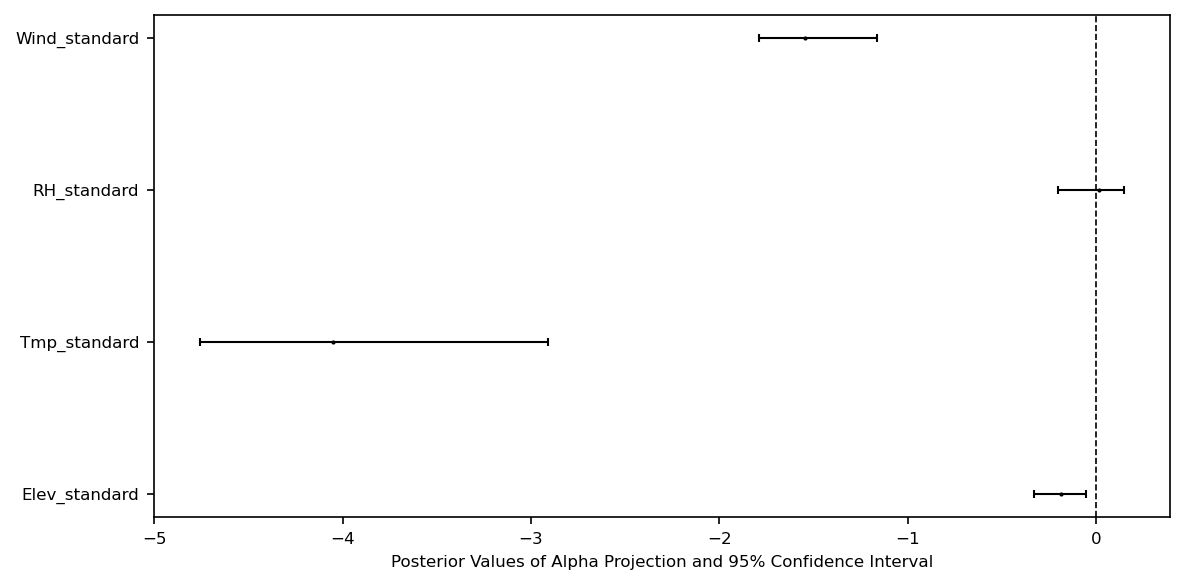

In [39]:
plt.figure(figsize=(8, 4), dpi=150)

ci = [covar_info_df['X_alpha_mean'].values - covar_info_df['X_alpha_lo_ci'].values,
      covar_info_df['X_alpha_hi_ci'].values - covar_info_df['X_alpha_mean'].values]

plt.errorbar(x=covar_info_df['X_alpha_mean'].values, y=covar_info_df['Covar'].values,
             xerr=ci,
            color='black',  capsize=2, linestyle='None', linewidth=1,
            marker="o", markersize=1, mfc="black", mec="black")

plt.axvline(x=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Posterior Values of Alpha Projection and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

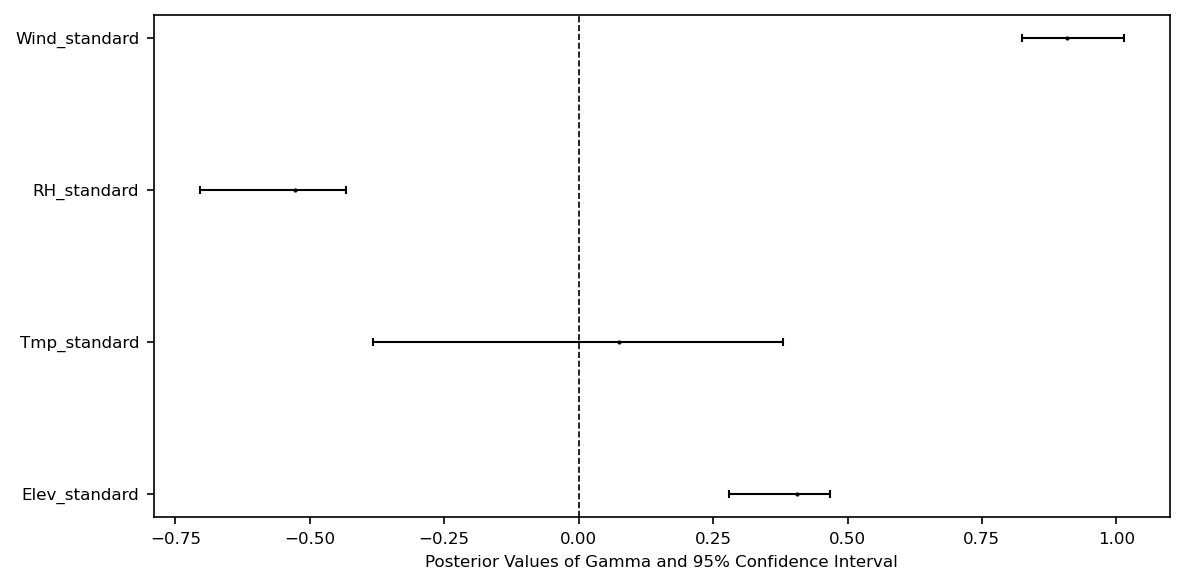

In [40]:
plt.figure(figsize=(8, 4), dpi=150)

ci = [covar_info_df['gamma_mean'].values - covar_info_df['gamma_ci_lo'].values,
      covar_info_df['gamma_ci_hi'].values - covar_info_df['gamma_mean'].values]

plt.errorbar(x=covar_info_df['gamma_mean'].values, y=covar_info_df['Covar'].values,
             xerr=ci,
            color='black',  capsize=2, linestyle='None', linewidth=1,
            marker="o", markersize=1, mfc="black", mec="black")

plt.axvline(x=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Posterior Values of Gamma and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

Get Estimated Slope Values

In [25]:
np.random.seed(1)

Fit Joint QR Models

In [26]:
from epa import *

In [27]:
from geopy.distance import geodesic

def haversine(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

In [28]:
wildfire_df_xu_sub['Long_adj'] = -1*np.abs(wildfire_df_xu_sub['Long'])

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/2579252573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfire_df_xu_sub['Long_adj'] = -1*np.abs(wildfire_df_xu_sub['Long'])


In [29]:
wildfire_df_xu_sub.head()

Elev   Lat  Long   Mdl  Tmp  RH  Wind   PPT  ERC  BI  ...   ADJ   I  \
0   663.0  34.7  86.4   7G    91  47     4  0.00   32  25  ...    M   12   
1   970.0  34.3  87.3   7G    86  56     3  0.00   28  22  ...    M    7   
2  1200.0  34.4  85.6   7G    72  71     2  0.00   20  13  ...    L    2   
3  1104.0  33.9  86.3   7G    79  74     1  0.31   21  13  ...    M    2   
4  1050.0  33.7  85.7   8G    84  48     1  0.00   28  28  ...    M   11   

     State  Elev_standard  Tmp_standard RH_standard Wind_standard  \
0     None      -0.860827      0.192982   -0.139785     -0.714286   
1  Alabama      -0.797994      0.017544    0.053763     -0.785714   
2  Alabama      -0.750921     -0.473684    0.376344     -0.857143   
3     None      -0.770569     -0.228070    0.440860     -0.928571   
4  Alabama      -0.781621     -0.052632   -0.118280     -0.928571   

   PPT_standard BI_standard  Long_adj  
0     -1.000000   -0.605249     -86.4  
1     -1.000000   -0.694147     -87.3  
2     -1.000000   -0.960842     -85.6  
3     -0.814371   -0.960842     -86.3  
4     -1.000000   -0.516350     -85.7  

[5 rows x 26 columns]

In [30]:
# Set x var
x_var = wildfire_df_xu_sub[["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]].values
y_var = wildfire_df_xu_sub['BI_standard'].values

z_lat = wildfire_df_xu_sub['Lat'].values
z_lon = wildfire_df_xu_sub['Long_adj'].values
z_lon_alt = wildfire_df_xu_sub['Long'].values
num_points = len(z_lat)
distance_matrix = np.zeros((num_points, num_points))
distance_matrix_alt = np.zeros((num_points, num_points))

for i in range(num_points):
    for j in range(num_points):
        distance_matrix[i, j] = haversine(z_lat[i], z_lon[i], z_lat[j], z_lon[j])
        distance_matrix_alt[i, j] = haversine(z_lat[i], z_lon_alt[i], z_lat[j], z_lon_alt[j])


In [31]:
# Convert to similarity matrix
d_norm = distance_matrix/np.max(distance_matrix)
sim_mat = 1-d_norm + 0.01

d_norm_alt = distance_matrix_alt/np.max(distance_matrix_alt)
sim_mat_alt = 1-d_norm_alt + 0.01

Do Agglo Clustering on Distance Matrix First

In [32]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

clustering = AgglomerativeClustering(n_clusters=3, linkage='average')
agglo_pre_clusters = clustering.fit_predict(sim_mat)

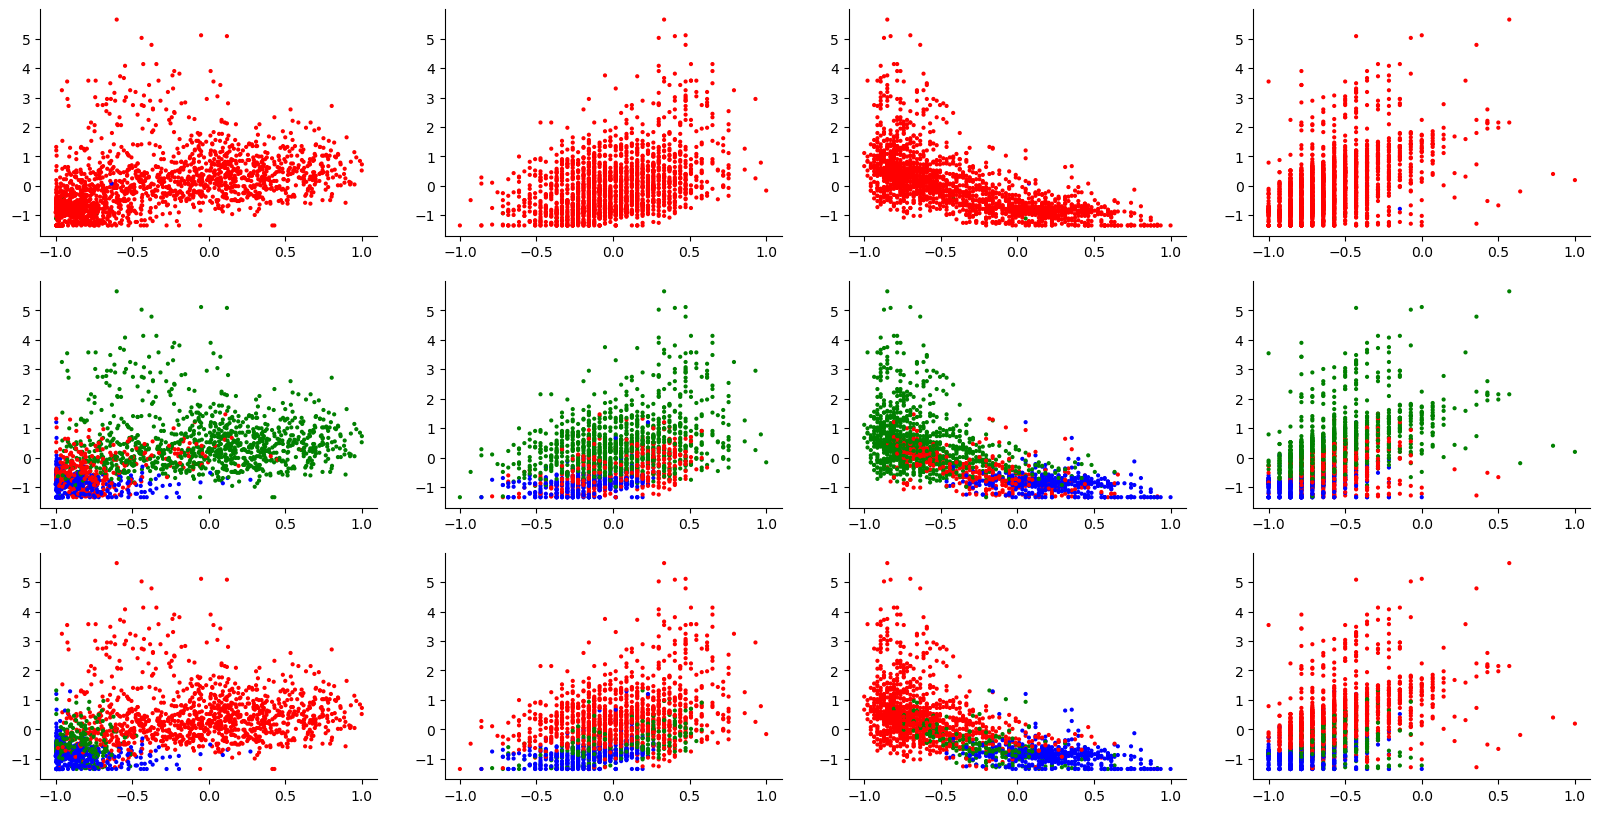

In [33]:
fig,ax = plt.subplots(3,4,figsize=(20,10))
agglo_cols = ['red','blue','green']

for ax_id_row, c_type in enumerate(['single','complete','average']):
    
    clustering = AgglomerativeClustering(n_clusters=3, linkage=c_type)
    agglo_pre_clusters = clustering.fit_predict(sim_mat)

    for ax_id_col, x_var_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]): 
    
        ax[ax_id_row, ax_id_col].scatter(x=wildfire_df_xu_sub[x_var_name],
                   y=wildfire_df_xu_sub['BI_standard'], s=4,
                  color=[agglo_cols[i] for i in agglo_pre_clusters])
        
        ax[ax_id_row, ax_id_col].spines[['right', 'top']].set_visible(False)


In [34]:
wildfire_df_xu_sub['Long_adj'] = -1*np.abs(wildfire_df_xu_sub['Long'])

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/2579252573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfire_df_xu_sub['Long_adj'] = -1*np.abs(wildfire_df_xu_sub['Long'])


In [115]:
import plotly.express as px

clustering = AgglomerativeClustering(n_clusters=3, linkage='average')
agglo_pre_clusters = clustering.fit_predict(sim_mat)
agglo_pre_clust_prefix = np.array(['C' + x for x in agglo_pre_clusters.astype('str')])
wildfire_df_xu_sub['Agglo_clusters'] = agglo_pre_clust_prefix

color_list = ['red', 'blue', 'green', 'darkorange', 'black', 'purple', 'brown']
color_dict_map = {'C'+str(i): color_list[i] for i in range(len(color_list))}

# Assuming wildfire_data_df_xu is your DataFrame
fig = px.scatter_geo(wildfire_df_xu_sub, lat='Lat', 
                     lon='Long_adj', color='Agglo_clusters',
                     hover_data=wildfire_df_xu_sub.columns, scope='usa',
                    color_discrete_map=color_dict_map)

fig.update_traces(marker=dict(size=5))  # Adjust the size as needed

fig.update_geos(showcountries=True, countrycolor="Black", showsubunits=True, subunitcolor="Black")

fig.update_layout(title='Wildfire Data Map of the USA with State Boundaries',
                  geo=dict(showland=True, landcolor="whitesmoke"))

fig.show()


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/3213389651.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



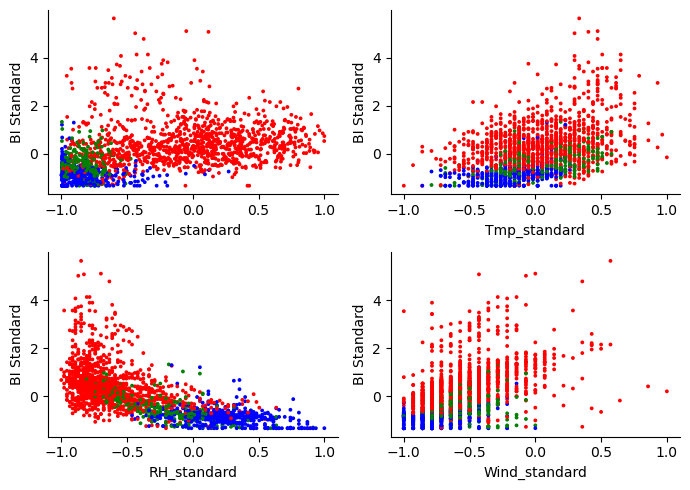

In [114]:
fig ,ax = plt.subplots(2,2, figsize=(7,5))
col_pos_ids = [(0,0),(0,1),(1,0),(1,1)]
for ax_id_col, x_var_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]): 

    ax[col_pos_ids[ax_id_col][0], col_pos_ids[ax_id_col][1]].scatter(x=wildfire_df_xu_sub[x_var_name],
               y=wildfire_df_xu_sub['BI_standard'], s=3,
              color=[agglo_cols[i] for i in agglo_pre_clusters])
    ax[col_pos_ids[ax_id_col][0], col_pos_ids[ax_id_col][1]].set_xlabel(x_var_name)
    ax[col_pos_ids[ax_id_col][0], col_pos_ids[ax_id_col][1]].set_ylabel('BI Standard')
    ax[col_pos_ids[ax_id_col][0], col_pos_ids[ax_id_col][1]].spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('Exp Results/Xu Dataset/Multivar Run 4/pre_clustering_plot.png')


In [38]:
Ys = y_var
Xs = x_var

if len(x_var.shape) > 1:
    multivariate_x = True
    n_covar = x_var.shape[1]
else:
    multivariate_x = False
    

In [39]:
np.random.seed(1234)

In [40]:
start_time = time.time()

c1_params = chain_outputs[0]

lambda_init = 'tight' # 'standard'/'tight'

# similarity mat
tau = 2
#lambda_matrix = pairwise_distances(X=Zs.reshape(-1,1), metric=exp_sim_func, tau=tau)
lambda_matrix = sim_mat

# Calc lambda

# intialize 
names_used = np.array([1,2])
alpha_samp = 1

# try with good distance function
#partition_samp = inds_train.copy()



# Scramble initialization after
partition_samp = np.array([1 if np.random.uniform(0,1)<0.5 else 2 for x in range(len(Xs))])  # try no initialization
partition_init  = partition_samp.astype('int')

delta_samp = 0
sim_mat = lambda_matrix
order_samp = np.arange(len(Ys))
np.random.shuffle(order_samp)


#### gibbs sampling hyper parameters
n_gibbs = 2000
n_burn_in = 1000
k = 400 # no. of numbers to permute order
n_chain = 2

# GRW sampler param
rw_sd = 0.2

# alpha prior -> Want alpha to be small,  gammma prior so mean = a/b
alpha_init = 0.005
a_alpha = 1
b_alpha = 200
alpha_bounds = [0,1e99]

# delta prior -> Want delta to be smal lalso gammma prior so mean = a/b
a_delta = 1
b_delta = 100
w_delta = 0.5
delta_bounds = [0,1]
delta_init = 0

# Tau prior
sample_tau = False
tau_bounds = [0,99]
a_tau = 4
b_tau = 2
tau_init = 1

labels_used = np.array([1,2])

reordering = True
use_split_merge_step = False


# phi sample - w1, w2, mu,gamma,sigma1,sigma2 - store as a vector

##############################
#### initialize QR Params ####
##############################
splice = True
m = 9

if multivariate_x:
    if not prior_on_t:
        phi_init = np.zeros([len(labels_used),
                        m+m+3+n_covar+n_covar]) # two GPs, mu,sigm1,sigma2, gamma (n_covar), x_alpha(n_covar)
    else:
        phi_init = np.zeros([len(labels_used),
                        m+m+4+n_covar + n_covar]) # Same as above but with v
else:
    if not prior_on_t:
        phi_init = np.zeros([len(labels_used), 
                        m+m+4])
    else:
        phi_init = np.zeros([len(labels_used),
                        m+m+5])

# Set tau grid
#tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
#tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
knot_points_grid = np.arange(0.1,1,0.1)
m = len(knot_points_grid)

eta1_init = np.zeros([len(labels_used),
                     len(tau_grid)])
eta2_init = np.zeros([len(labels_used),
                     len(tau_grid)])
    
# Get lambda PDF
h=0.1
lambd_collect = calc_lambd_grid_uncorr(knot_points_grid.reshape(-1,1),
                                    h=h,
                                    rho_lambd_init=0.99)
lambd_grid = np.array(lambd_collect)
grid_pdf_vals = lamb_pdf(lambd_grid)
lambda_grid_log_prob = np.log(grid_pdf_vals)

#### Initialize Model Parameters
## GP Related hyperparameters
kappa_current = np.nan
rho_current = 0.1
lambd_current = 4
alpha_kappa = 3
beta_kappa = 1/3

## Regression related parametrs
mu_current = 0
gamma_current = 0
sigma_1_current = 1
sigma_2_current = 1


#### W samples 
# calc covariance matrix
cov_mat_knots_current = covariance_matrix_gp_uncorr(knot_points_grid.reshape(-1,1),
                                  lambd=lambd_current)
# Precompute Matrices
cov_matrices_G, A_matrices_G = precompute_approx_uncorr(tau_grid_expanded.reshape(-1,1),
                                                   knot_points_grid.reshape(-1,1),
                                                   lambda_grid=lambd_grid)

for j in range(len(labels_used)):
    
    # Initialise w1, w2 knots 
    w1_knot_points_current_j = np.array(c1_params['w1_knot'][n_steps-200:n_steps-1]).mean(0)

    w2_knot_points_current_j = np.array(c1_params['w2_knot'][n_steps-200:n_steps-1]).mean(0)

    
    remain_params_j = np.concatenate([np.array([np.array(c1_params['mu'][n_steps-200:n_steps-1]).mean(0)]),
                                      np.array(c1_params['gamma'][n_steps-200:n_steps-1]).mean(0),
                                      np.array([np.array(c1_params['sigma_1'][n_steps-200:n_steps-1]).mean(0),
                                                np.array(c1_params['sigma_2'][n_steps-200:n_steps-1]).mean(0)])])


    if prior_on_t:
        v_hat = np.array(c1_params['v'][n_steps-200:n_steps-1]).mean()
    else:
        v_hat=1.0
    
    
    if multivariate_x:
        X_alpha_current_j = np.array(c1_params['X_alpha'][n_steps-200:n_steps-1]).mean(0)

        if prior_on_t:
        # Store into phi_j
            phi_j = np.concatenate([w1_knot_points_current_j,
                                    w2_knot_points_current_j,
                                    remain_params_j, np.array([v_hat]),
                                    X_alpha_current_j])
        else:
            phi_j = np.concatenate([w1_knot_points_current_j,
                                w2_knot_points_current_j,
                                remain_params_j,
                                    X_alpha_current_j])
    else:
        X_alpha_current_j = None
        if prior_on_t:
        # Store into phi_j
            phi_j = np.concatenate([w1_knot_points_current_j,
                                    w2_knot_points_current_j,
                                    remain_params_j,
                                    np.array([v_hat])])
        else:
            phi_j = np.concatenate([w1_knot_points_current_j,
                                    w2_knot_points_current_j,
                                    remain_params_j])

    phi_init[j] = phi_j
    
    #### Get associated Quantile Function for each phi_j ####
    w1_knot_prop = w1_knot_points_current_j
    w2_knot_prop = w2_knot_points_current_j
    # Get approx
    w1_approx_prop_j, lp_w1_j = calc_mixture_knot_approx_marginalized(w1_knot_prop,
                                                                    a_kappa=alpha_kappa,
                                                                    b_kappa=beta_kappa,
                                                                    tau_grid=tau_grid_expanded,
                                                                    A_g_matrices=A_matrices_G,
                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                    lambda_grid_log_prob=lambda_grid_log_prob)
    
    w2_approx_prop_j, lp_w2_j = calc_mixture_knot_approx_marginalized(w2_knot_prop,
                                                                    a_kappa=alpha_kappa,
                                                                    b_kappa=beta_kappa,
                                                                    tau_grid=tau_grid_expanded,
                                                                    A_g_matrices=A_matrices_G,
                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                    lambda_grid_log_prob=lambda_grid_log_prob)
    # Get Q function
    mu_j, gamma_j, sigma1_j, sigma2_j = phi_j[18],phi_j[19],phi_j[20],phi_j[21]

    # get Eta functions
    eta_1_j  = eta_function_i_vector(tau_input=tau_grid,
                               w_vals=w1_approx_prop_j,
                               tau_grid=tau_grid_expanded,
                               mean=0.0,
                               sd=1.0,
                               v=v_hat,
                               sigma=sigma1_j,
                               dist=quantile_dist)

    eta_2_j  = eta_function_i_vector(tau_input=tau_grid,
                           w_vals=w2_approx_prop_j,
                           tau_grid=tau_grid_expanded,
                           mean=0.0,
                           sd=1.0,
                           v=v_hat,
                           sigma=sigma2_j,
                           dist=quantile_dist)

    eta1_init[j] = eta_1_j
    eta2_init[j] = eta_2_j

In [41]:
phi_init.shape

(2, 30)

In [42]:
Ys = y_var
Xs = x_var
Zs = None
sim_mat = sim_mat
partition_init = partition_init
phi_init = phi_init

tau_init =   tau_init
labels_used = labels_used
alpha_init = alpha_init
delta_init = delta_init
n_gibbs = n_gibbs
n_burn_in = n_burn_in
k = k
a_alpha = a_alpha
b_alpha = b_alpha
a_delta = a_delta
b_delta = b_delta
a_tau =  a_tau
b_tau =  b_tau
w_delta = 0.5
reordering = reordering
use_split_merge_step = use_split_merge_step
sample_tau = False

In [43]:
n = len(Ys)
# intialize 
names_used = labels_used
alpha_samp = alpha_init

delta_samp = delta_init
order_samp = np.arange(n)
np.random.shuffle(order_samp)

# initialize QR params
phi_samp = phi_init
eta1_samp = eta1_init
eta2_samp = eta2_init

partition_samp = partition_init
tau_samp = tau_init


#### gibbs sampling hyper parameters
n_gibbs = n_gibbs
k = k # no. of numbers to permute order

# GRW sampler param
rw_sd = 0.2

# alpha prior
a_alpha = a_alpha
b_alpha = b_alpha
alpha_bounds = [0,1e99]

# delta prior
a_delta = a_delta
b_delta = b_delta

assert (w_delta<=1) and (w_delta>=0)
w_delta = w_delta
delta_bounds = [0,1]
tau_bounds = [0,1e99]


partition_save = []
alpha_save = []
delta_save = []
phi_save = []
log_prob_save = []
sigma_reg_save = []
tau_save = []

# Track acceptance rates
split_merge_accept_save = []
tau_accept_save = []
delta_accept_save = []
order_accept_save = []
alpha_accept_save = []


s1 = time.time()
# Gibbs loop
for g in range(n_gibbs+n_burn_in):
    if g%50 == 0:
        e1 = time.time()
        print("Gibbs: ", g, " Time Taken: ", (e1-s1)/60)
        print("Active No Clusters: ", len(np.unique(partition_samp)))
        print("Active No Clusters: ", pd.Series(partition_samp).value_counts())
        s1 = time.time()

    # Get last term in order samp
    #last_term_samp = order_samp[-1]
    last_term_id = order_samp[-1]#np.where(order_samp == np.max(order_samp))[0][0]

    #print('Partition Update')
    # Draw sample for the final term
    if prior_on_t:
        v_samp = phi_samp[-1]
    else:
        v_samp = 1.0
    
    partition_samp, phi_samp, names_used, \
        partition_factors, eta1_samp, eta2_samp = sample_conditional_i_clust_gibbs_opti_parallel_QR(
                                    i=last_term_id,
                                    order_place=0,
                                    partition=partition_samp,
                                    return_fac=True,
                                    pre_compute_factors=np.zeros(1),
                                    alpha=alpha_samp,
                                    delta=delta_samp,
                                    sim_mat=sim_mat,
                                    order=order_samp,
                                    phi=phi_samp,
                                    eta1_mat=eta1_samp, 
                                    eta2_mat=eta2_samp,
                                    y=Ys,
                                    x=Xs,
                                    A_matrices_G = A_matrices_G,
                                    cov_matrices_G = cov_matrices_G,
                                    lambda_grid_log_prob= lambda_grid_log_prob,
                                       w_cov_mat=cov_mat_knots_current,
                                      alpha_kappa=5,
                                      beta_kappa=1/3,
                                      tau_grid=tau_grid,
                                      tau_grid_expanded=tau_grid_expanded,
                                    base_quantile_mean=0.0,
                                     base_quantile_sd=1.0,
                                     base_quantile_v=v_samp,
                                     base_quantile_dist=quantile_dist,
                                    names_used=names_used,                      
                                    reordering=reordering,
                                    splice=splice,
                                    prior_on_t=prior_on_t,
                                        multivariate_x=multivariate_x)
    
    for o in list(range(len(order_samp)-2,-1,-1)):

        term_id = order_samp[o]#np.where(order_samp == o)[0][0]

        partition_samp, phi_samp, names_used,\
              eta1_samp, eta2_samp= sample_conditional_i_clust_gibbs_opti_parallel_QR(
                                        i=term_id,
                                        order_place=o,
                                        partition=partition_samp,
                                        return_fac=False,
                                        pre_compute_factors=partition_factors,
                                        alpha=alpha_samp,
                                        delta=delta_samp,
                                        sim_mat=sim_mat,
                                        order=order_samp,
                                        phi=phi_samp,
                                        eta1_mat=eta1_samp, 
                                        eta2_mat=eta2_samp,
                                        y=Ys,
                                        x=Xs,
                                        A_matrices_G = A_matrices_G,
                                    cov_matrices_G = cov_matrices_G,
                                    lambda_grid_log_prob= lambda_grid_log_prob,
                                    
                                           w_cov_mat=cov_mat_knots_current,
                                          alpha_kappa=5,
                                          beta_kappa=1/3,
                                          tau_grid=tau_grid,
                                          tau_grid_expanded=tau_grid_expanded,
                                        base_quantile_mean=0.0,
                                         base_quantile_sd=1.0,
                                         base_quantile_v=v_samp,
                                         base_quantile_dist=quantile_dist,
                                        names_used=names_used,
                                        reordering=reordering,
                                            prior_on_t=prior_on_t,
                                            multivariate_x=multivariate_x)

    """
    if use_split_merge_step:
    #### Split Merge step ####
        partition_samp,phi_samp, names_used,\
        sigma2_reg_samp, accept_samp = split_merge_step(partition_samp=partition_samp,
                                                    alpha=alpha_samp,
                                                    delta=delta_samp,
                                                    sim_mat=sim_mat,
                                                    order=order_samp,
                                                    phi_samp=phi_samp,
                                                    y=Ys,
                                                    x=Xs, 
                                                    sigma2_reg_samp=sigma2_reg_samp,
                                                    v_0=v_0,
                                                    sigma2_0=sigma2_0,
                                                    names_used=names_used, 
                                                    phi_base_mean=phi_mean_prior,
                                                    phi_base_cov=phi_cov_prior,
                                                    no_intermediate_steps=5)

        if g>n_burn_in:

            split_merge_accept_save.append(accept_samp)
    """

    partition_samp = partition_samp.astype('int')

    
    #print("Sampling Phi")
    phi_samp, eta1_samp, eta2_samp = sample_phi_QR(phi_cur=phi_samp,
                           eta1_cur=eta1_samp,
                           eta2_cur=eta2_samp,
                           n_steps=200,
                           y=Ys,
                           x=Xs,
                            A_matrices_G = A_matrices_G,
                        cov_matrices_G = cov_matrices_G,
                        lambda_grid_log_prob= lambda_grid_log_prob,
                        cov_mat_knots_init=cov_mat_knots_current,
                           partition=partition_samp,
                          tau_grid=tau_grid,
                           tau_grid_expanded=tau_grid_expanded,
                           base_quantile_mean=0.0,
                           base_quantile_sd=1.0,
                           base_quantile_v=1.0,
                          base_quantile_dist=quantile_dist,
                          prior_on_t=prior_on_t)

    # Sample ordering 
    #order_samp = permute_k(order_samp, k)
    #print("Sample Order")
    order_samp,order_accept_s = metropolis_step_order(order_current=order_samp,
                                    alpha=alpha_samp,
                                    delta=delta_samp,
                                    partition=partition_samp,
                                    sim_mat=sim_mat,
                                    k=k)

    if g>n_burn_in:
        order_accept_save.append(order_accept_s)

    #### Sample parameters, alpha, sigma
    #print("Sampling Alpha")
    alpha_samp, alpha_accept_s = metropolis_step_alpha(alpha_samp,
                                                    rw_sd,
                                                    a_alpha, b_alpha,
                                                    partition_samp,
                                                        delta_samp,
                                                        sim_mat,
                                                        order_samp,
                                                    bounds=alpha_bounds)

    if g>n_burn_in:
        alpha_accept_save.append(alpha_accept_s)

    #print("Sampling Delta")
    delta_samp, delta_accept_s = metropolis_step_delta(delta_samp, rw_sd,
                                                    a_delta, b_delta, w_delta,
                                                    partition_samp,
                                                        alpha_samp,
                                                        sim_mat,
                                                        order_samp,bounds=delta_bounds)

    if g>n_burn_in:
        delta_accept_save.append(delta_accept_s)

    # Update Tau + Sim mat
    if sample_tau:
        tau_samp, sim_mat, tau_accept_s = metropolis_step_tau(tau_samp, rw_sd, a_tau, b_tau,
                            partition_samp,
                                alpha_samp,
                                delta_samp,
                                sim_mat,
                                X=Zs.reshape(-1,1),
                        order=order_samp,bounds=tau_bounds)

        if g>n_burn_in:
            tau_accept_save.append(tau_accept_s)

    """
    # Calc log prob of result
    log_prob_samp = calc_log_joint(partition=partition_samp,
                                phi=phi_samp,
                                y=Ys,
                                x=Xs,
                                sim_mat=sim_mat,
                                order=order_samp,
                                alpha=alpha_samp,
                                delta=delta_samp,
                                sigma_reg = sigma_reg)
    """

    if g>n_burn_in:

        # Save sampled values
        #log_prob_save.append(log_prob_samp)
        partition_save.append(partition_samp)
        alpha_save.append(alpha_samp)
        delta_save.append(delta_samp)
        phi_save.append(phi_samp)
        tau_save.append(tau_samp)


acceptance_rates = {'Split Merge': np.mean(split_merge_accept_save),
                    'Tau': np.mean(tau_accept_save),
                    'Delta': np.mean(delta_accept_save),
                    'Order': np.mean(order_accept_save),
                    'Alpha': np.mean(alpha_accept_save)}

acceptance_rates = pd.DataFrame.from_dict(acceptance_rates, orient='index')
acceptance_rates.columns=['Acceptance Rate']
acceptance_rates


Gibbs:  0  Time Taken:  8.14994176228841e-06
Active No Clusters:  2
Active No Clusters:  1    927
2    925
Name: count, dtype: int64


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Gibbs:  50  Time Taken:  35.928372248013815
Active No Clusters:  3
Active No Clusters:  1    1077
2     565
3     210
Name: count, dtype: int64
Gibbs:  100  Time Taken:  35.47504750092824
Active No Clusters:  3
Active No Clusters:  1    1050
2     626
3     176
Name: count, dtype: int64
Gibbs:  150  Time Taken:  34.97349255084991
Active No Clusters:  3
Active No Clusters:  1    1079
2     653
3     120
Name: count, dtype: int64
Gibbs:  200  Time Taken:  35.89037365516027
Active No Clusters:  3
Active No Clusters:  1    937
2    760
3    155
Name: count, dtype: int64
Gibbs:  250  Time Taken:  35.52111442089081
Active No Clusters:  3
Active No Clusters:  1    977
2    776
3     99
Name: count, dtype: int64
Gibbs:  300  Time Taken:  34.88879979848862
Active No Clusters:  3
Active No Clusters:  1    1023
2     677
3     152
Name: count, dtype: int64
Gibbs:  350  Time Taken:  35.83301995197932
Active No Clusters:  3
Active No Clusters:  1    1043
2     658
3     151
Name: count, dtype: int6

Gibbs:  2950  Time Taken:  34.89324771960576
Active No Clusters:  3
Active No Clusters:  1    1037
2     695
3     120
Name: count, dtype: int64


/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



Acceptance Rate
Split Merge              NaN
Tau                      NaN
Delta               0.000000
Order               0.037519
Alpha               0.056028

In [101]:
import pickle

# Define the file path
file_path = 'Exp Results/Xu Dataset/Multivar Run 4/'

# Pickle partition_save
with open(file_path + 'partition_save.pkl', 'wb') as f:
    pickle.dump(partition_save, f)

# Pickle alpha_save
with open(file_path + 'alpha_save.pkl', 'wb') as f:
    pickle.dump(alpha_save, f)

# Pickle delta_save
with open(file_path + 'delta_save.pkl', 'wb') as f:
    pickle.dump(delta_save, f)

# Pickle phi_save
with open(file_path + 'phi_save.pkl', 'wb') as f:
    pickle.dump(phi_save, f)

# Pickle tau_save
with open(file_path + 'tau_save.pkl', 'wb') as f:
    pickle.dump(tau_save, f)


Get clustering matrix

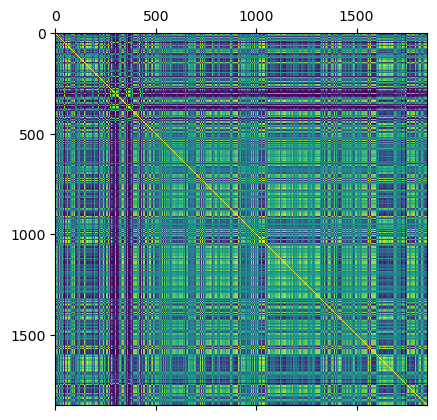

In [46]:
cluster_size_samples = np.array([len(np.unique(p)) for p in partition_save])
np.mean(cluster_size_samples)


normalized_sim_mat = calc_hit_matrix(partition_save,
                                     burn_samples=0,
                                     normalize=True)

plt.matshow(normalized_sim_mat)
plt.show()

In [119]:
len(partition_save[0])

1852

In [47]:
np.mean(cluster_size_samples)


3.071535767883942

### Plot Clusters

/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



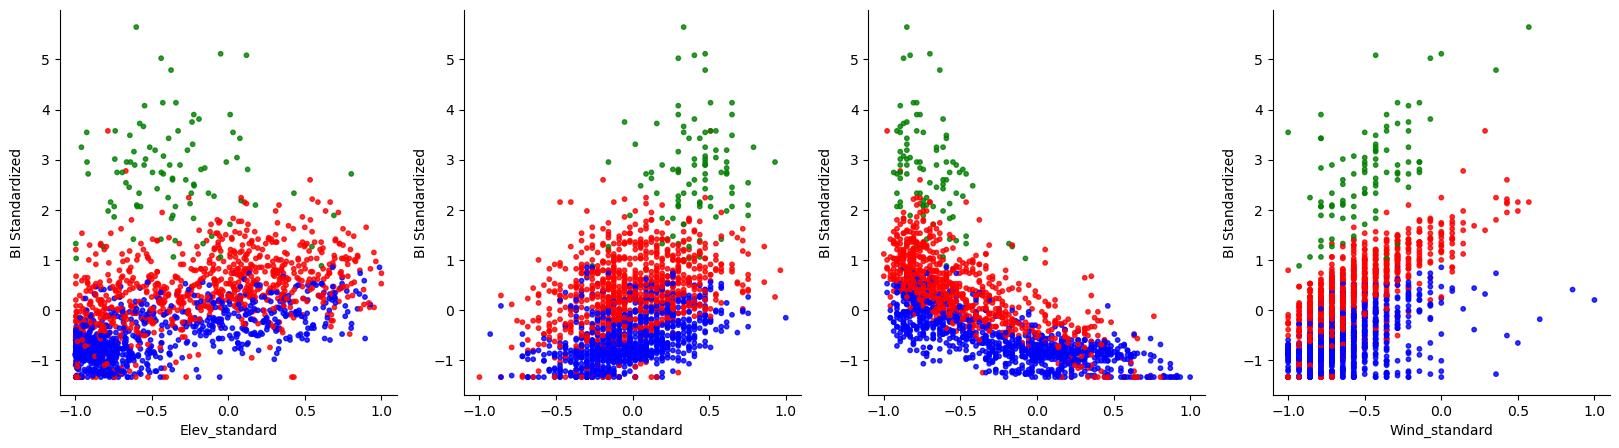

In [49]:
agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=3,
                                       linkage_type='complete')

fig, ax = plt.subplots(1,4,figsize=(20,5))

for j,covar_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):
    ax[j].scatter(Xs[:,j], Ys,
                s=10,
               color=[agglo_cols[i] for i in agglo_cluster_solution], alpha=0.8)


    ax[j].set_xlabel(covar_name)
    ax[j].set_ylabel('BI Standardized')
    ax[j].spines[['right', 'top']].set_visible(False)
plt.savefig('Exp Results/Xu Dataset/Multivar Run 4/Clustering_plot.png')

plt.show()


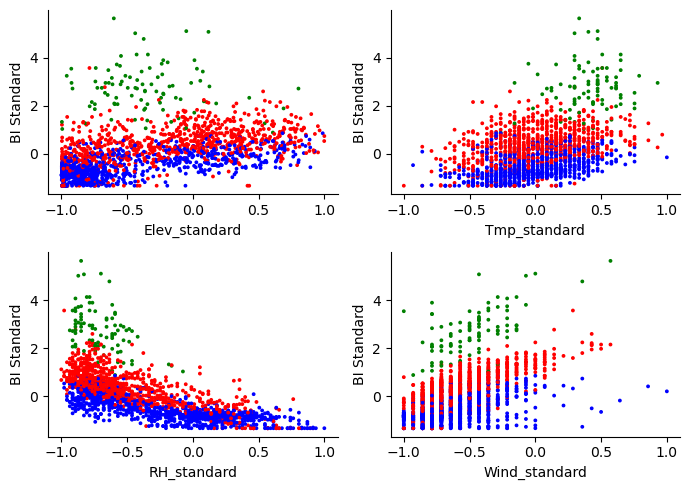

In [117]:
fig ,ax = plt.subplots(2,2, figsize=(7,5))
col_pos_ids = [(0,0),(0,1),(1,0),(1,1)]
for ax_id_col, x_var_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]): 

    ax[col_pos_ids[ax_id_col][0], col_pos_ids[ax_id_col][1]].scatter(x=wildfire_df_xu_sub[x_var_name],
               y=wildfire_df_xu_sub['BI_standard'], s=3,
              color=[agglo_cols[i] for i in agglo_cluster_solution])
    
    ax[col_pos_ids[ax_id_col][0], col_pos_ids[ax_id_col][1]].set_xlabel(x_var_name)
    ax[col_pos_ids[ax_id_col][0], col_pos_ids[ax_id_col][1]].set_ylabel('BI Standard')
    ax[col_pos_ids[ax_id_col][0], col_pos_ids[ax_id_col][1]].spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('Exp Results/Xu Dataset/Multivar Run 4/Clustering_plot_grid.png')


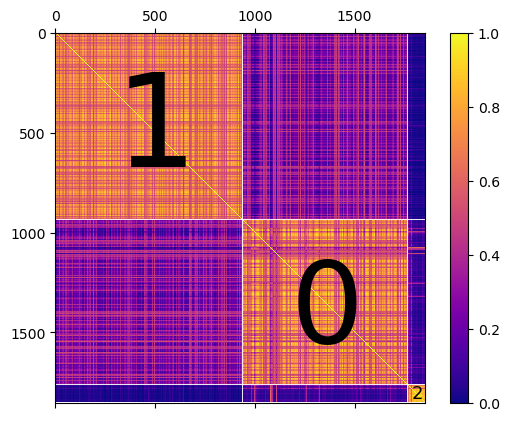

In [96]:
# Calculate c-vals
c_vals = calc_c_vals(agglo_cluster_solution, normalized_sim_mat)

sorted_clust_names = pd.Series(agglo_cluster_solution).value_counts().index

arranged_ids = []
for c in sorted_clust_names:

    clust_ids = np.where(agglo_cluster_solution==c)[0]
    c_vals_clust = c_vals[clust_ids]
    sorted_clust_ids =clust_ids[np.argsort(c_vals_clust)[::-1]]
    
    arranged_ids.append(sorted_clust_ids)
    
arranged_ids = np.concatenate(arranged_ids)

sorted_matrix = np.zeros((len(Ys),len(Ys)))

for i in range(len(Ys)):
    for j in range(len(Ys)):
        
        sorted_matrix[i,j] = normalized_sim_mat[arranged_ids[i], arranged_ids[j]]

figure = plt.figure()
axes = figure.add_subplot(111)

caxes = axes.matshow(sorted_matrix, cmap='plasma')
figure.colorbar(caxes)

clust_sizes = pd.Series(agglo_cluster_solution).value_counts().values

for clust_size,clust_name, n in zip(clust_sizes,sorted_clust_names,clust_sizes.cumsum()):
    
    axes.axvline(n-1,c='white',lw=0.65)
    axes.axhline(n-1,c='white',lw=0.65)
    
    if clust_name in [0,1]:
        axes.text(n-clust_size//2-170, n-clust_size//2+200, str(clust_name), color="k", fontsize=clust_size/10)
    else:
        axes.text(n-clust_size//2-20, n-clust_size//2+25, str(clust_name), color="k", fontsize=clust_size/7)


plt.savefig('Exp Results/Xu Dataset/Multivar Run 4/mixture_QR_conf_plot.png')
plt.show()

In [97]:
1 in sorted_clust_names

True

In [98]:
pd.Series(agglo_cluster_solution).value_counts()

1    935
0    826
2     91
Name: count, dtype: int64

### Plot Clusters on Map

In [103]:
import plotly.express as px

agglo_cluster_solution_with_prefix = np.array(['C' + x for x in agglo_cluster_solution.astype('str')])
wildfire_df_xu_sub['posterior_clusters'] =agglo_cluster_solution_with_prefix


color_list = ['red', 'blue', 'green', 'darkorange', 'black', 'purple', 'brown']
color_dict_map = {'C'+str(i): color_list[i] for i in range(len(color_list))}

# Assuming wildfire_data_df_xu is your DataFrame
fig = px.scatter_geo(wildfire_df_xu_sub, lat='Lat',
                     lon='Long_adj', color='posterior_clusters',
                     scope='usa',color_discrete_map=color_dict_map,
                    hover_data=wildfire_df_xu_sub.columns)
                     
fig.update_traces(marker=dict(size=5))  # Adjust the size as needed
fig.update_geos(showcountries=True,
                countrycolor="Black",
                showsubunits=True, subunitcolor="Black")

fig.update_layout(title='Wildfire Data Map of the USA with State Boundaries - Posterior Clusters',
                  geo=dict(showland=True, landcolor="whitesmoke"))

fig.show()
#fig.write_image("Exp Results/Xu Dataset/Run 1/Elev/posterior_cluster_map.png")

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/2859110805.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Do exemplar Modelling

In [53]:
color_list = ['red','blue',
            'green','darkorange','black','purple','brown']

In [54]:
# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

c_id = cluster_ids[2]

# Extract points in that cluster
cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

# Choose k and get top k point
k = int(len(cluster_member_id)*0.05)
point_wise_scores = np.sum(points_sim, 1)
sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k]

cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]

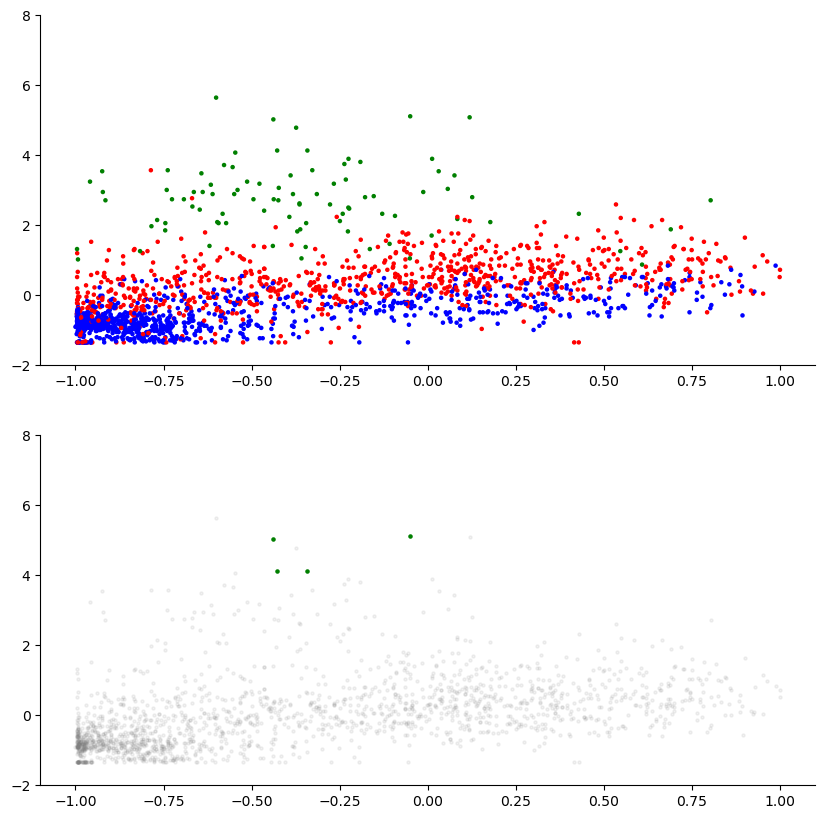

In [55]:
# Plot for sanity check
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].scatter(Xs[:,0], Ys, c=[color_list[i] for i in agglo_cluster_solution],alpha=1, s=5)
ax[0].set_ylim([-2,8])
ax[0].spines[['right', 'top']].set_visible(False)


# Plot exemplar
ax[1].scatter(Xs[:,0], Ys, c='gray',alpha=0.1, s=5)
ax[1].set_ylim([-2,8])
ax[1].spines[['right', 'top']].set_visible(False)


xs_cluster = Xs[cluster_exemplar_ids]
ys_cluster = Ys[cluster_exemplar_ids]
ax[1].scatter(xs_cluster[:,0], ys_cluster, c=color_list[c_id],alpha=1, s=5)

In [56]:
for c_id in np.sort(cluster_ids):
    
    # Extract points in that cluster
    cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
    points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

    # Choose k and get top k point
    k = int(len(cluster_member_id)*0.05)
    point_wise_scores = np.sum(points_sim, 1)
    sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k]

    cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]


    beta_0_save = []
    beta_1_save = []

    beta_weight = []

    for phi_samp, partition_samp in zip(phi_save,partition_save):

        exemplar_partitions = partition_samp[cluster_exemplar_ids]

In [57]:
X_train = Xs
y_train = Ys

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/2068969404.py:138: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/2068969404.py:138: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/2068969404.py:138: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/2068969404.py:138: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n

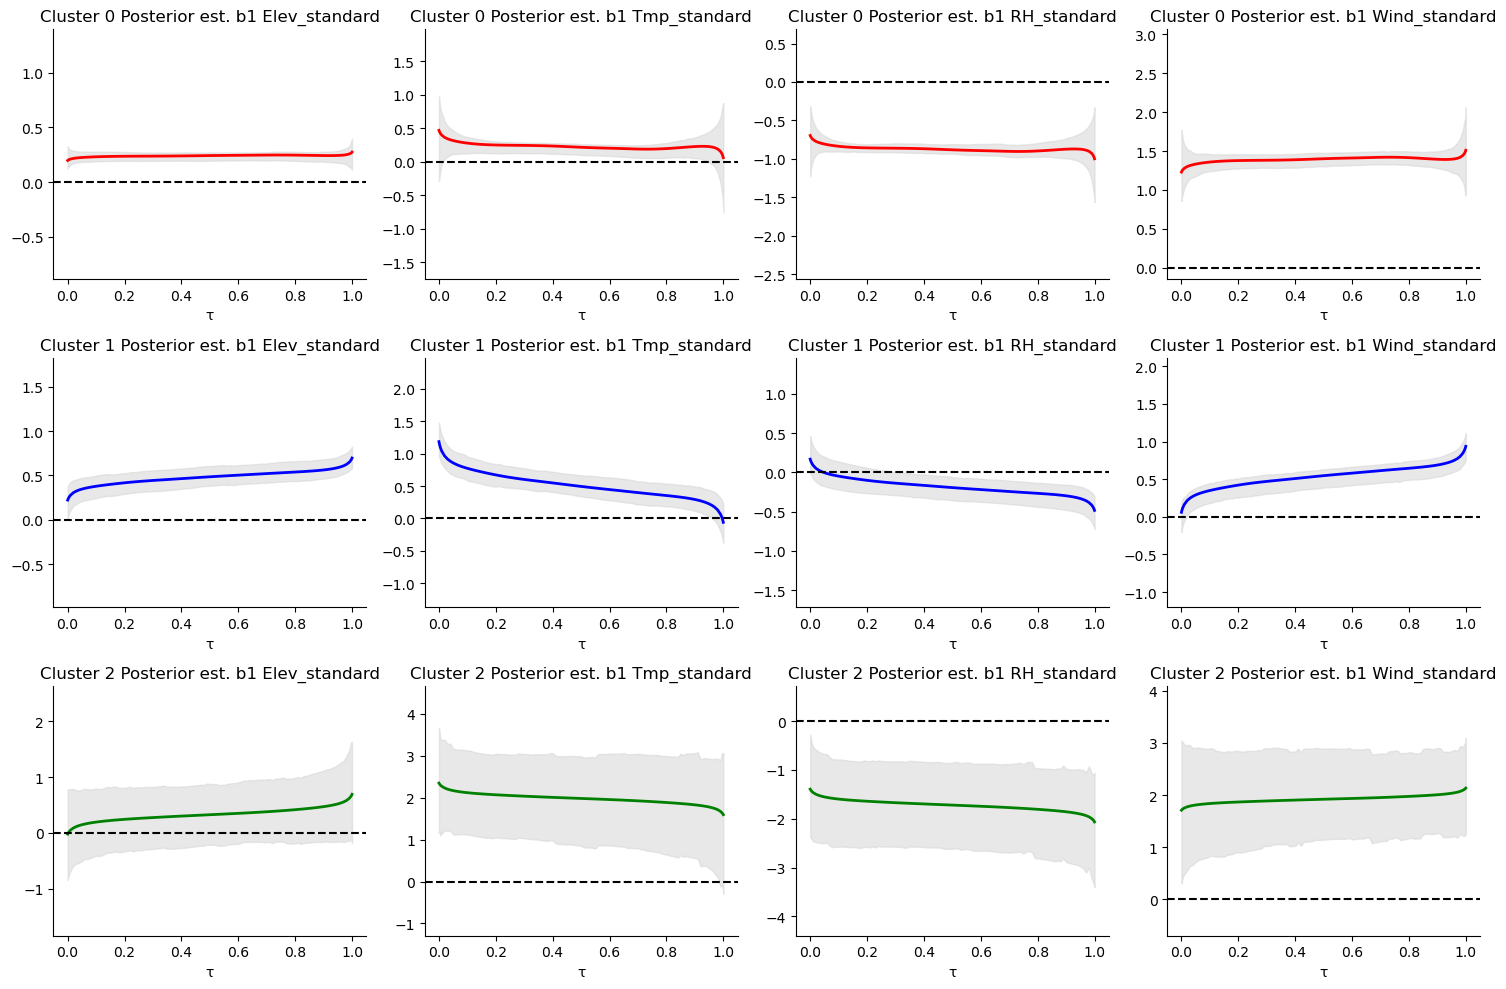

In [58]:
# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

fig, ax = plt.subplots(len(cluster_ids), n_covar, figsize=(5*len(cluster_ids),10))

for c_id in np.sort(cluster_ids):
    
    # Extract points in that cluster
    cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
    points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

    # Choose k and get top k point
    k_size = int(len(cluster_member_id)*0.05)
    point_wise_scores = np.sum(points_sim, 1)
    sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k_size]

    cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]


    beta_0_save = []
    beta_1_save = []

    beta_weight = []

    for phi_samp, partition_samp in zip(phi_save,partition_save):
        
        # Extract cluster ids of points chosen as exemplars
        exemplar_partitions = partition_samp[cluster_exemplar_ids]
        
        for k in np.unique(exemplar_partitions):

            # Get count
            p_count = np.sum(exemplar_partitions==k)

            # Extract phi
            phi_samp_clust = phi_samp[k-1,:]

            if multivariate_x:
                if prior_on_t:
                    m = (len(phi_samp_clust)-4 - 2*n_covar)//2
                else:
                    m = (len(phi_samp_clust)-3 - 2*n_covar)//2
            else:
                if prior_on_t:
                    m = (len(phi_samp_clust)-5)//2
                else:
                    m = (len(phi_samp_clust)-4)//2

            w1_knot_points_current = phi_samp_clust[0:m]
            w2_knot_points_current = phi_samp_clust[m:2*m]
            mu_current = phi_samp_clust[2*m]
            gamma_current = phi_samp_clust[2*m+1: 2*m+1+n_covar]


            sigma_1_current = phi_samp_clust[2*m+1+n_covar]
            sigma_2_current = phi_samp_clust[2*m+1+n_covar + 1]

            if prior_on_t:
                v_current = phi_samp_clust[2*m+1+n_covar + 2]
                x_alpha_current = phi_samp_clust[2*m+1+n_covar + 3 : 2*m+1+n_covar + 3 + n_covar]  # Fix

            else:
                v_current = base_quantile_v
                v_prop = base_quantile_v
                x_alpha_current = phi_samp_clust[2*m+1+n_covar + 2 : 2*m+1+n_covar + 2 +n_covar]  # Fix
                
            
            # Extract all points that would have been in that cluster (for calculating projection)
            

            # Generate sample of GP approx
            w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            # Project x
            # First extract all x points in given partition to calculate X_a and X_b
            x_vals_k_all = X_train[np.where(partition_samp==k)[0]]
            if len(x_vals_k_all) == 1:
                continue
            projx, X_ak, X_bk = project_x(x_vals_k_all, x_alpha_current, return_ab = True)
            
            
            # Generate Q
            eta_1  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w1_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_1_current,
                                dist=quantile_dist)

            eta_2  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w2_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_2_current,
                                dist=quantile_dist)
            
            # Generate beta samples
            beta_1_samp = (gamma_current + (np.expand_dims((1/(2*X_bk))*(eta_2-eta_1),1)*x_alpha_current))
            # Get beta samp
            #beta_0_samp = mu_current + (eta_1 + eta_2)/2
            #beta_1_samp = gamma_current + (eta_1 - eta_2)/2

            #beta_0_save.append(beta_0_samp)
            beta_1_save.append(beta_1_samp)

            beta_weight.append(p_count)


    #beta_0_expanded = np.vstack([b0 for b0, count in zip(beta_0_save, beta_weight) for _ in range(count)])
    beta_1_expanded = np.array([b1 for b1, count in zip(beta_1_save, beta_weight) for _ in range(count)])
    
    # Remove anomaly values
    beta_1_expanded = beta_1_expanded * (np.abs(beta_1_expanded) < 1e3).astype('float')

    # Get covariate wise means
    b1_c_mean = np.mean(beta_1_expanded,0)    
    
    # Get CIs
    for cov_id, cov_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):
        b1_c_cis = az.hdi(beta_1_expanded[:,:,cov_id])


        # Plot values
        ax[c_id,cov_id].plot(tau_grid, b1_c_mean[:,cov_id], color=color_list[c_id],lw=2)
        ax[c_id,cov_id].fill_between(tau_grid, b1_c_cis[:,0],
                        b1_c_cis[:,1], color='lightgray', alpha=.5)

        ax[c_id,cov_id].title.set_text(f"Cluster {c_id} Posterior est. b1 {cov_name}")

        ax[c_id,cov_id].set_xlabel('τ')
        
        ax[c_id,cov_id].axhline(y=0,linestyle='--', c = 'black')
        
        max_val = np.max(b1_c_cis[:,1])
        min_val = np.min(b1_c_cis[:,0])
        
        ax[c_id,cov_id].set_ylim([min_val-1,max_val+1])

        ax[c_id,cov_id].spines[['right', 'top']].set_visible(False)
    
plt.tight_layout()
plt.savefig(f'Exp Results/Xu Dataset/Multivar Run 4/Exemplar_slopes.png')
plt.show()


Same plot but with intercept

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/3226804236.py:140: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/3226804236.py:162: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/3226804236.py:162: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_16913/3226804236.py:162: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n

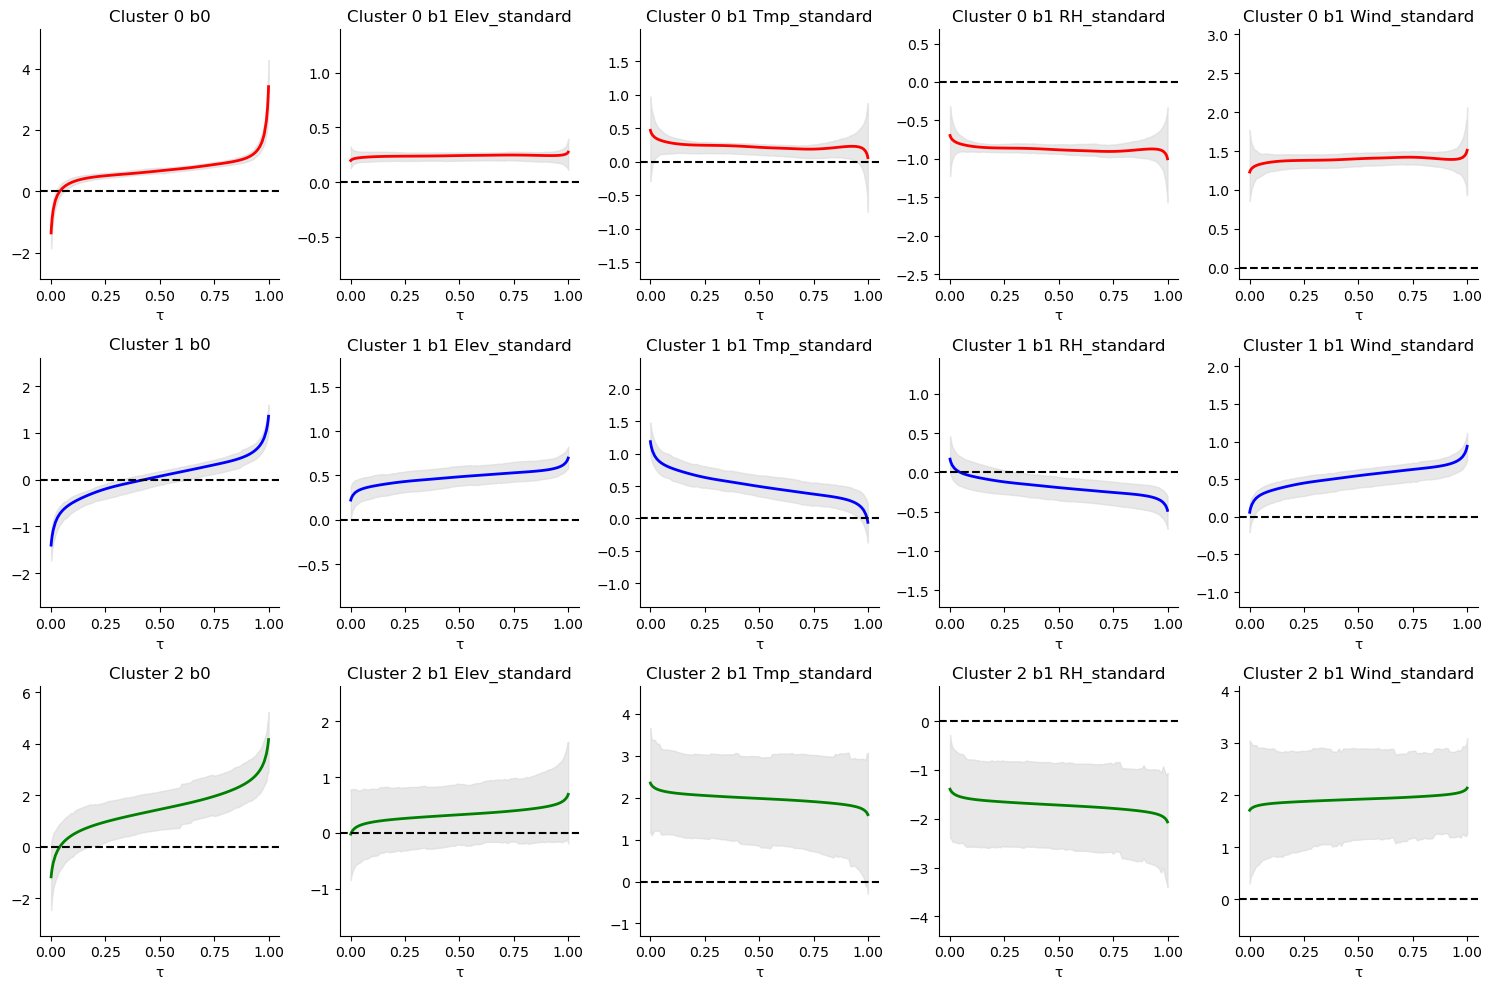

In [59]:
# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

fig, ax = plt.subplots(len(cluster_ids), 1+n_covar, figsize=(5*len(cluster_ids),10))

for c_id in np.sort(cluster_ids):
    
    # Extract points in that cluster
    cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
    points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

    # Choose k and get top k point
    k_size = int(len(cluster_member_id)*0.05)
    point_wise_scores = np.sum(points_sim, 1)
    sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k_size]

    cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]


    beta_0_save = []
    beta_1_save = []

    beta_weight = []

    for phi_samp, partition_samp in zip(phi_save,partition_save):
        
        # Extract cluster ids of points chosen as exemplars
        exemplar_partitions = partition_samp[cluster_exemplar_ids]
        
        for k in np.unique(exemplar_partitions):

            # Get count
            p_count = np.sum(exemplar_partitions==k)

            # Extract phi
            phi_samp_clust = phi_samp[k-1,:]

            if multivariate_x:
                if prior_on_t:
                    m = (len(phi_samp_clust)-4 - 2*n_covar)//2
                else:
                    m = (len(phi_samp_clust)-3 - 2*n_covar)//2
            else:
                if prior_on_t:
                    m = (len(phi_samp_clust)-5)//2
                else:
                    m = (len(phi_samp_clust)-4)//2

            w1_knot_points_current = phi_samp_clust[0:m]
            w2_knot_points_current = phi_samp_clust[m:2*m]
            mu_current = phi_samp_clust[2*m]
            gamma_current = phi_samp_clust[2*m+1: 2*m+1+n_covar]


            sigma_1_current = phi_samp_clust[2*m+1+n_covar]
            sigma_2_current = phi_samp_clust[2*m+1+n_covar + 1]

            if prior_on_t:
                v_current = phi_samp_clust[2*m+1+n_covar + 2]
                x_alpha_current = phi_samp_clust[2*m+1+n_covar + 3 : 2*m+1+n_covar + 3 + n_covar]  # Fix

            else:
                v_current = base_quantile_v
                v_prop = base_quantile_v
                x_alpha_current = phi_samp_clust[2*m+1+n_covar + 2 : 2*m+1+n_covar + 2 +n_covar]  # Fix
                
            
            # Extract all points that would have been in that cluster (for calculating projection)
            

            # Generate sample of GP approx
            w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            # Project x
            # First extract all x points in given partition to calculate X_a and X_b
            x_vals_k_all = X_train[np.where(partition_samp==k)[0]]
            if len(x_vals_k_all) == 1:
                continue
            projx, X_ak, X_bk = project_x(x_vals_k_all, x_alpha_current, return_ab = True)
            
            
            # Generate Q
            eta_1  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w1_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_1_current,
                                dist=quantile_dist)

            eta_2  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w2_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_2_current,
                                dist=quantile_dist)
            
            # Generate beta samples
            beta_1_samp = (gamma_current + (np.expand_dims((1/(2*X_bk))*(eta_2-eta_1),1)*x_alpha_current))
            beta_0_samp = mu_current + 0.5*(eta_2+eta_1) - 0.5*(eta_2-eta_1)*(X_ak/X_bk)
            # Get beta samp
            #beta_0_samp = mu_current + (eta_1 + eta_2)/2
            #beta_1_samp = gamma_current + (eta_1 - eta_2)/2

            beta_0_save.append(beta_0_samp)
            beta_1_save.append(beta_1_samp)

            beta_weight.append(p_count)


    beta_0_expanded = np.vstack([b0 for b0, count in zip(beta_0_save, beta_weight) for _ in range(count)])
    beta_1_expanded = np.array([b1 for b1, count in zip(beta_1_save, beta_weight) for _ in range(count)])
    
    # Remove anomaly values
    beta_1_expanded = beta_1_expanded * (np.abs(beta_1_expanded) < 1e3).astype('float')
    beta_0_expanded = beta_0_expanded * (np.abs(beta_0_expanded) < 1e3).astype('float')

    # Get covariate wise means
    b1_c_mean = np.mean(beta_1_expanded,0)    
    b0_c_mean = np.mean(beta_0_expanded,0)    
    
    # Get intercept CI
    b0_c_cis = az.hdi(beta_0_expanded)
  
    # Plot beta 0 
    ax[c_id, 0].plot(tau_grid, b0_c_mean, color=color_list[c_id],lw=2)
    ax[c_id, 0].fill_between(tau_grid, b0_c_cis[:,0],
                    b0_c_cis[:,1], color='lightgray', alpha=.5)

    ax[c_id, 0].title.set_text(f"Cluster {c_id} b0")

    ax[c_id, 0].set_xlabel('τ')

    ax[c_id, 0].axhline(y=0,linestyle='--', c = 'black')

    max_val = np.max(b0_c_cis[:,1])
    min_val = np.min(b0_c_cis[:,0])

    ax[c_id, 0].set_ylim([min_val-1,max_val+1])

    ax[c_id, 0].spines[['right', 'top']].set_visible(False)

    # Get CIs
    for cov_id, cov_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):
        b1_c_cis = az.hdi(beta_1_expanded[:,:,cov_id])

        # Plot values
        ax[c_id,cov_id+1].plot(tau_grid, b1_c_mean[:,cov_id], color=color_list[c_id],lw=2)
        ax[c_id,cov_id+1].fill_between(tau_grid, b1_c_cis[:,0],
                        b1_c_cis[:,1], color='lightgray', alpha=.5)

        ax[c_id,cov_id+1].title.set_text(f"Cluster {c_id} b1 {cov_name}")

        ax[c_id,cov_id+1].set_xlabel('τ')
        
        ax[c_id,cov_id+1].axhline(y=0,linestyle='--', c = 'black')
        
        max_val = np.max(b1_c_cis[:,1])
        min_val = np.min(b1_c_cis[:,0])
        
        ax[c_id,cov_id+1].set_ylim([min_val-1,max_val+1])

        ax[c_id,cov_id+1].spines[['right', 'top']].set_visible(False)
    
plt.tight_layout()
plt.savefig(f'Exp Results/Xu Dataset/Multivar Run 4/Exemplar_slopes_with_intercept.png')
plt.show()


### Plot posterior quantile lines

In [60]:
def extract_submatrix(in_mat, delete_pos):
    return np.delete(in_mat, delete_pos)

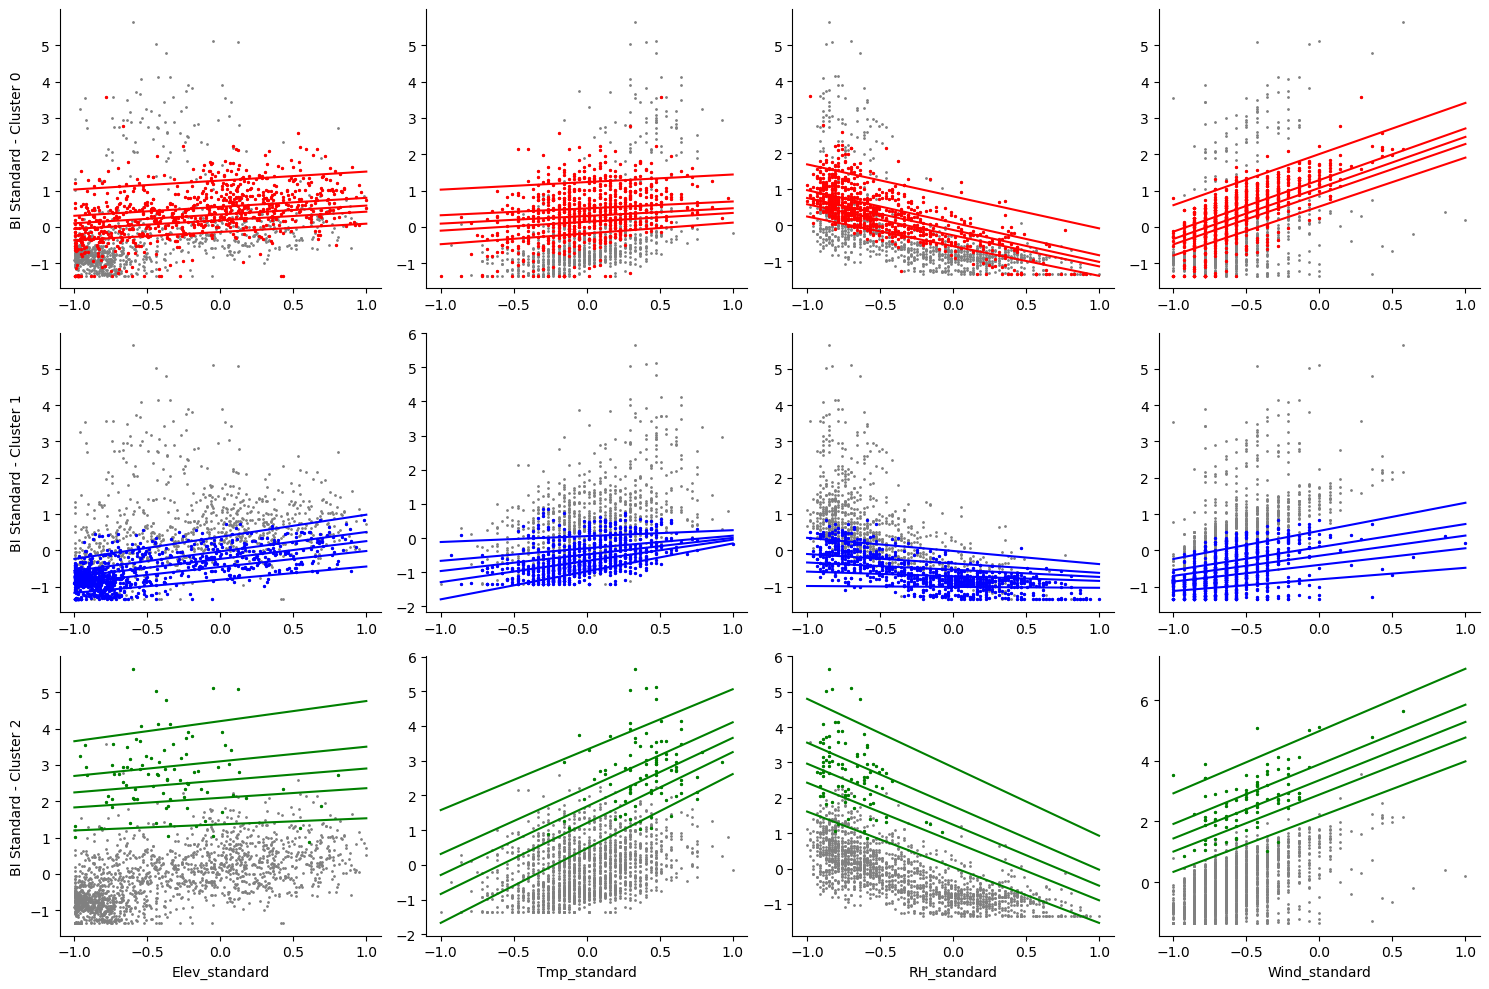

In [61]:
# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

fig, ax = plt.subplots(len(cluster_ids), n_covar, figsize=(5*len(cluster_ids),10))

for c_id in np.sort(cluster_ids):
    
    # Extract points in that cluster
    cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
    points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

    # Choose k and get top k point
    k_size = int(len(cluster_member_id)*0.05)
    point_wise_scores = np.sum(points_sim, 1)
    sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k_size]

    cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]


    beta_0_save = []
    beta_1_save = []
    
    # Also need to save gamma, eta2 eta 1, alpha, b
    gamma_save = []
    eta_1_save = []
    eta_2_save = []
    alpha_save = []
    b_save = []
    
    beta_weight = []

    for phi_samp, partition_samp in zip(phi_save,partition_save):
        
        # Extract cluster ids of points chosen as exemplars
        exemplar_partitions = partition_samp[cluster_exemplar_ids]
        
        for k in np.unique(exemplar_partitions):

            # Get count
            p_count = np.sum(exemplar_partitions==k)

            # Extract phi
            phi_samp_clust = phi_samp[k-1,:]

            if multivariate_x:
                if prior_on_t:
                    m = (len(phi_samp_clust)-4 - 2*n_covar)//2
                else:
                    m = (len(phi_samp_clust)-3 - 2*n_covar)//2
            else:
                if prior_on_t:
                    m = (len(phi_samp_clust)-5)//2
                else:
                    m = (len(phi_samp_clust)-4)//2

            w1_knot_points_current = phi_samp_clust[0:m]
            w2_knot_points_current = phi_samp_clust[m:2*m]
            mu_current = phi_samp_clust[2*m]
            gamma_current = phi_samp_clust[2*m+1: 2*m+1+n_covar]


            sigma_1_current = phi_samp_clust[2*m+1+n_covar]
            sigma_2_current = phi_samp_clust[2*m+1+n_covar + 1]

            if prior_on_t:
                v_current = phi_samp_clust[2*m+1+n_covar + 2]
                x_alpha_current = phi_samp_clust[2*m+1+n_covar + 3 : 2*m+1+n_covar + 3 + n_covar]  # Fix

            else:
                v_current = base_quantile_v
                v_prop = base_quantile_v
                x_alpha_current = phi_samp_clust[2*m+1+n_covar + 2 : 2*m+1+n_covar + 2 +n_covar]  # Fix
                
            
            # Extract all points that would have been in that cluster (for calculating projection)
            

            # Generate sample of GP approx
            w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            # Project x
            # First extract all x points in given partition to calculate X_a and X_b
            x_vals_k_all = X_train[np.where(partition_samp==k)[0]]
            y_vals_k_all = y_train[np.where(partition_samp==k)[0]]
            if len(x_vals_k_all) == 1:
                continue
            projx, X_ak, X_bk = project_x(x_vals_k_all, x_alpha_current, return_ab = True)
            
            
            # Generate Q
            eta_1  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w1_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_1_current,
                                dist=quantile_dist)

            eta_2  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w2_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_2_current,
                                dist=quantile_dist)
            
            # Generate beta samples
            beta_1_samp = (gamma_current + (np.expand_dims((1/(2*X_bk))*(eta_2-eta_1),1)*x_alpha_current))
            beta_0_samp = mu_current + 0.5*(eta_2+eta_1) - 0.5*(eta_2-eta_1)*(X_ak/X_bk)
            

            beta_0_save.append(beta_0_samp)
            beta_1_save.append(beta_1_samp)
            
            gamma_save.append(gamma_current)
            eta_1_save.append(eta_1)
            eta_2_save.append(eta_2)
            alpha_save.append(x_alpha_current)
            b_save.append(X_bk)

            beta_weight.append(p_count)


    beta_0_expanded = np.vstack([b0 for b0, count in zip(beta_0_save, beta_weight) for _ in range(count)])
    beta_1_expanded = np.array([b1 for b1, count in zip(beta_1_save, beta_weight) for _ in range(count)])
    
    # Expand other variables
    gamma_expanded = np.vstack([g for g, count in zip(gamma_save, beta_weight) for _ in range(count)])
    eta_1_expanded = np.vstack([g for g, count in zip(eta_1_save, beta_weight) for _ in range(count)])
    eta_2_expanded = np.vstack([g for g, count in zip(eta_2_save, beta_weight) for _ in range(count)])
    alpha_expanded = np.vstack([g for g, count in zip(alpha_save, beta_weight) for _ in range(count)])
    b_var_expanded = np.vstack([g for g, count in zip(b_save, beta_weight) for _ in range(count)])
    
    
    # Remove anomaly values
    beta_1_expanded = beta_1_expanded * (np.abs(beta_1_expanded) < 1e3).astype('float')
    beta_0_expanded = beta_0_expanded * (np.abs(beta_0_expanded) < 1e3).astype('float')

    # Get covariate wise means
    b1_c_mean = np.mean(beta_1_expanded,0)    
    b0_c_mean = np.mean(beta_0_expanded,0)    
    
    # Get intercept CI
    # Get CIs
    x_vals_k_all_plot = X_train[np.where(agglo_cluster_solution==c_id)[0]]
    y_vals_k_all = y_train[np.where(agglo_cluster_solution==c_id)[0]]
    
    # Calculate cluster means
    x_vals_k_all_mean = x_vals_k_all_plot.mean(0)
    
    # calculate addition intercept terms
    gamma_mean = gamma_expanded.mean(0)
    eta_1_mean = eta_1_expanded.mean(0)
    eta_2_mean = eta_2_expanded.mean(0)
    alpha_expanded_mean = alpha_expanded.mean(0)
    b_var_expanded_mean = b_var_expanded.mean(0)
    

    for cov_id, cov_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):

        
        x_vals_k_all_mean_wanted = extract_submatrix(x_vals_k_all_mean, cov_id)
        gamma_wanted = extract_submatrix(gamma_mean,cov_id)
        alpha_wanted = extract_submatrix(alpha_expanded_mean, cov_id)
        
        b0_additional = (x_vals_k_all_mean_wanted@gamma_wanted) +\
            ((eta_2_mean - eta_1_mean)/(2*b_var_expanded_mean)) *\
        (x_vals_k_all_mean_wanted@alpha_wanted)


        
        
        # Grab x and y vals
        x_cov_k = x_vals_k_all_plot[:,cov_id]
        
        # Plot values
        ax[c_id,cov_id].scatter(X_train[:,cov_id], y_train, c='gray', s=1)
        ax[c_id,cov_id].scatter(x_cov_k, y_vals_k_all, c=color_list[c_id], s=2)
        
        # Plot Lines
        sample_quantiles = [0.05,0.25,0.5,0.75,0.95]
        sample_quantile_inds = [np.argwhere(tau_grid_expanded==q)[0][0] for q in sample_quantiles]
        x_grid = np.linspace(min(X_train[:,cov_id]), max(X_train[:,cov_id]), 20)
        
        for sample_quantile_id in sample_quantile_inds:
            
            b0_sq = b0_c_mean[sample_quantile_id]
            b1_sq = b1_c_mean[sample_quantile_id,cov_id]
            
            y_pred = b0_sq + x_grid*b1_sq + b0_additional[sample_quantile_id]
            
            ax[c_id,cov_id].plot(x_grid, y_pred, c=color_list[c_id])

        ax[c_id,cov_id].spines[['right', 'top']].set_visible(False)
        
        if cov_id == 0:
            ax[c_id,cov_id].set_ylabel(f'BI Standard - Cluster {c_id}')
        
        if c_id == 2:
            ax[c_id,cov_id].set_xlabel(cov_name)

    
plt.tight_layout()
plt.savefig(f'Exp Results/Xu Dataset/Multivar Run 4/Exemplar_lines.png')
plt.show()